In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif, SelectKBest

In [665]:
train_data = pd.read_csv("ready_gene_expression_data.csv", index_col=0, sep="\t").transpose()
X = train_data
y = "".join([
    "00000000000000000000000000000000000000000000000000",
    "00000000000000000000000000000000000000000000000000",
    "00000000000000000000000000000000000000000000000000",
    "00000000000000000000000000000000000000000000000000",
    "00000000000000000000000000000000000000000000000000",
    "00000000000000000000000000000000000000000000000000",
    "00000000000000000001111111111111111111111111111111",
    "11111111"
])
y = np.array(list(y), dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# FILTER METHODS

## ANOVA

In [730]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(score_func=f_classif, k=100)
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)


X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

anova_features_index = np.where(selector.get_support())[0]
selected_features = X_train.columns[selector.get_support()]
# Scale the features
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[29  3]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.40      0.50      0.44         4

    accuracy                           0.86        36
   macro avg       0.67      0.70      0.68        36
weighted avg       0.88      0.86      0.87        36



In [693]:
list(X_train.columns[anova_features_index])

['1552846_s_at',
 '1554258_a_at',
 '1554701_a_at',
 '1555540_at',
 '1555711_x_at',
 '1558176_at',
 '1558438_a_at',
 '1559946_s_at',
 '1561937_x_at',
 '1562703_at',
 '1564154_at',
 '1564155_x_at',
 '1565535_x_at',
 '1569629_x_at',
 '1569765_at',
 '1569792_a_at',
 '201175_at',
 '201573_s_at',
 '201848_s_at',
 '201849_at',
 '202295_s_at',
 '202387_at',
 '202599_s_at',
 '202716_at',
 '202862_at',
 '203103_s_at',
 '203172_at',
 '203386_at',
 '203559_s_at',
 '203695_s_at',
 '203719_at',
 '204049_s_at',
 '204141_at',
 '204331_s_at',
 '204521_at',
 '204670_x_at',
 '204977_at',
 '205159_at',
 '205410_s_at',
 '205666_at',
 '206398_s_at',
 '207399_at',
 '208688_x_at',
 '209012_at',
 '209018_s_at',
 '209374_s_at',
 '209434_s_at',
 '209507_at',
 '210378_s_at',
 '210538_s_at',
 '210789_x_at',
 '210841_s_at',
 '211633_x_at',
 '211634_x_at',
 '211635_x_at',
 '211636_at',
 '211637_x_at',
 '211639_x_at',
 '211640_x_at',
 '211641_x_at',
 '211642_at',
 '211643_x_at',
 '211644_x_at',
 '211645_x_at',
 '2116

## FDR

In [669]:
def fisher_discriminant_ratio(X, y):
    classes = np.unique(y)
    mu_1 = X[y == classes[1]].mean(axis=0)
    mu_0 = X[y == classes[0]].mean(axis=0)
    sigma_1_sq = X[y == classes[1]].var(axis=0)
    sigma_0_sq = X[y == classes[0]].var(axis=0)
    fdr_values = (mu_1 - mu_0)**2 / (sigma_1_sq + sigma_0_sq)
    return fdr_values

In [787]:
top_k = 100  # Number of top features to select
# Feature selection using Fisher Discriminant Ratio
fdr_values = fisher_discriminant_ratio(X_train, y_train)
fdr_features_indices = np.argsort(fdr_values)[-top_k:]
selected_features = X_train.columns[fdr_features_indices]

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


[[29  3]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.25      0.25      0.25         4

    accuracy                           0.83        36
   macro avg       0.58      0.58      0.58        36
weighted avg       0.83      0.83      0.83        36



Since the improvement in reducing features through intersection there might be a certain number of redundant/uninformative features

## mRMR

In [83]:
import mrmr
from mrmr.pandas import mrmr_classif

In [672]:
mrmr_features = mrmr_classif(X=X_train, y=y_train, K=200)

100%|██████████| 200/200 [39:44<00:00, 11.92s/it]


In [673]:
mrmr_index = [X_train.columns.get_loc(col) for col in mrmr_features]

In [674]:
X_train_selected = X_train.iloc[:, mrmr_index]
X_val_selected = X_val.iloc[:, mrmr_index]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


[[31  1]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        32
           1       0.50      0.25      0.33         4

    accuracy                           0.89        36
   macro avg       0.71      0.61      0.64        36
weighted avg       0.87      0.89      0.87        36



## Relief

In [785]:
from ReliefF import ReliefF
fs = ReliefF(n_neighbors=2, n_features_to_keep=100)
fs.fit(np.array(X_train), y_train)
X_train_selected = fs.transform(np.array(X_train))
relief_feature_indices = fs.top_features[0:100]

In [786]:
X_val_selected = fs.transform(np.array(X_val))

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1, C=0.5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[26  6]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        32
           1       0.25      0.50      0.33         4

    accuracy                           0.78        36
   macro avg       0.59      0.66      0.60        36
weighted avg       0.85      0.78      0.81        36



In [788]:
intersection_filters = list(set.intersection(set(fdr_features_indices), set(mrmr_index), set(anova_features_index)))

In [789]:
X_train_selected = X_train.iloc[:, intersection_filters]
X_val_selected = X_val.iloc[:, intersection_filters]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[27  5]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.29      0.50      0.36         4

    accuracy                           0.81        36
   macro avg       0.61      0.67      0.62        36
weighted avg       0.86      0.81      0.83        36



<AxesSubplot: >

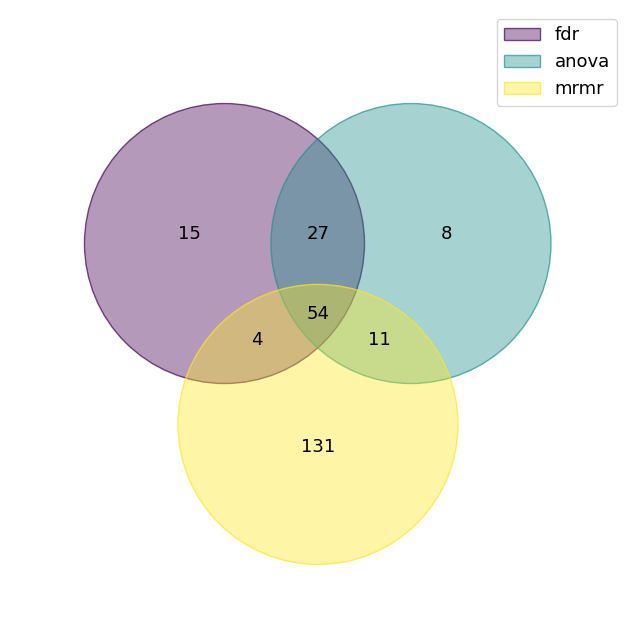

In [797]:
from venn import venn

genes_lists = {
    "fdr": set(fdr_features_indices),
    "anova": set(anova_features_index),
    #"relief": set(relief_feature_indices), # it has no intersection
    "mrmr": set(mrmr_index),
    #"ig":set(ga_selected_ig) 
}

venn(genes_lists)

## IG 

In [791]:
from sklearn.feature_selection import mutual_info_classif
selector = SelectKBest(score_func=mutual_info_classif, k=100)
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)


X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

ig_features_index = np.where(selector.get_support())[0]
selected_features = X_train.columns[selector.get_support()]
# Scale the features
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[30  2]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.50      0.50      0.50         4

    accuracy                           0.89        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.89      0.89      0.89        36



<AxesSubplot: >

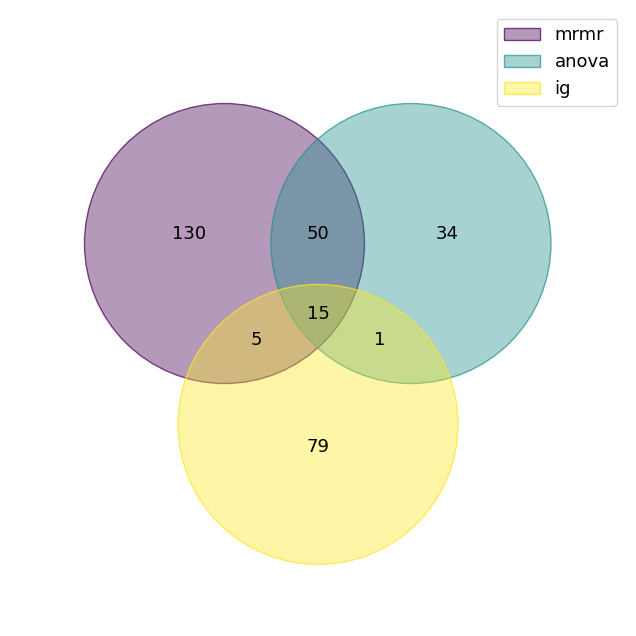

In [805]:
genes_lists = {
    #"fdr": set(fdr_features_indices),
    "mrmr": set(mrmr_index),
    "anova": set(anova_features_index), # it has no intersection
    #"mrmr": set(mrmr_index),
    "ig":set(ig_features_index)
}

venn(genes_lists)

## Heatmap

In [808]:
intersection_filters = list(set.intersection(set(fdr_features_indices), set(mrmr_index), set(anova_features_index)))

In [834]:
df

,217145_at,1559139_at,217466_x_at,218732_at,202716_at,210547_x_at,228077_at,211650_x_at,238417_at,1562703_at,...,203172_at,217892_s_at,1561937_x_at,218552_at,220994_s_at,1555755_at,216829_at,227947_at,242577_at,state
GSM7500930,9.857203,8.212375,13.348369,10.462400,10.503329,8.686150,10.546509,11.629083,7.923030,7.272397,...,10.064069,9.959278,10.265849,10.105516,7.169925,5.296457,10.933322,7.813781,5.285402,0
GSM7501036,10.868534,6.932215,12.383465,10.174677,10.799836,9.610600,10.159958,13.571554,8.749149,5.336855,...,10.309322,9.994208,13.205501,9.521355,7.416257,4.515889,12.125336,9.663932,5.295613,0
GSM7501203,11.815629,5.027066,12.199497,10.185009,10.228644,9.664602,10.151235,13.801678,8.799877,5.968390,...,9.877230,9.585473,13.483239,9.651330,6.087569,4.692371,12.666928,6.997868,2.522307,0
GSM7500914,7.906891,7.392317,10.672425,8.651052,9.359750,8.980140,10.542065,7.531381,8.968667,6.906891,...,8.933691,9.818582,11.210062,10.036174,4.584963,6.754888,7.870365,10.338736,7.000000,0
GSM7501023,8.800900,6.629357,11.103288,10.606405,10.222795,9.487840,10.225207,10.092757,8.405141,5.554589,...,9.296916,8.707359,10.657318,9.677720,4.523562,6.000000,9.843921,9.312883,7.266787,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM7501241,8.467606,8.199672,12.869979,10.361944,9.668885,5.209453,9.792790,12.827541,7.882643,4.954196,...,8.611025,8.573647,12.766529,9.884171,9.463524,5.754888,9.763212,6.832890,6.820179,1
GSM7501227,6.409391,8.067703,13.770468,10.198568,9.761219,7.193772,9.948221,7.259272,7.947783,7.096979,...,10.301039,8.951868,12.894117,7.363697,8.596190,6.157852,7.337176,6.024586,7.965784,1
GSM7501231,8.138528,7.678776,11.746304,10.201634,10.010388,6.334497,10.676574,11.052772,8.546894,5.429616,...,8.900263,10.444083,12.399225,9.994495,10.448736,6.756223,10.759555,4.906891,7.057450,1
GSM7501256,10.779719,8.129283,12.546412,9.879583,11.008429,7.434628,9.992938,12.773963,8.823367,6.845490,...,9.599913,8.957102,13.713064,9.840778,8.194757,6.807355,11.837628,5.807355,5.321928,1


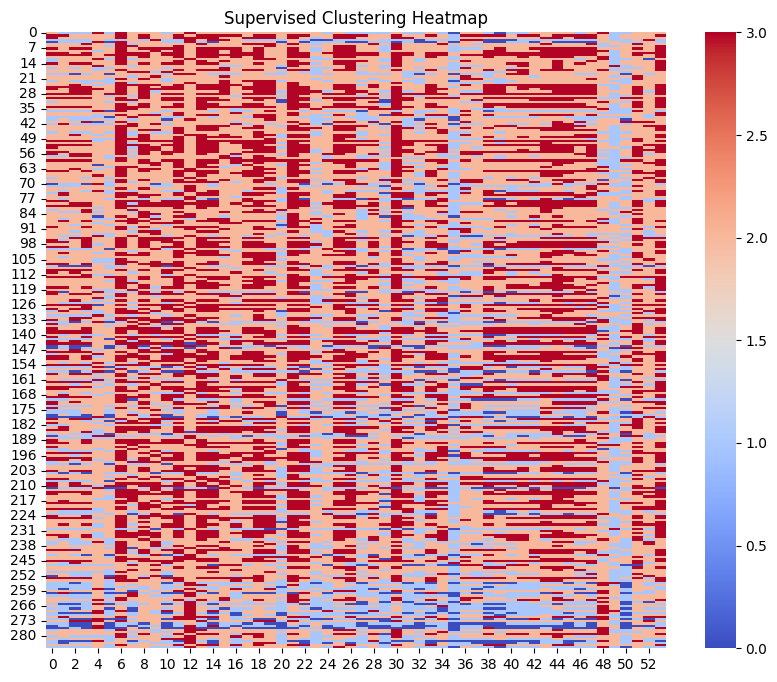

In [871]:
# def normalize_and_discretize(data):
#     # Normalize data
#     scaler = StandardScaler()
#     normalized_data = scaler.fit_transform(data)
    
#     # Discretize data into three partitions
#     bins = [-np.inf, -1.5, 1.5, np.inf]
#     discretized_data = np.digitize(normalized_data, bins) - 1
#     return discretized_data

# import matplotlib.pyplot as plt

scaler = MinMaxScaler()
df = X_train.iloc[:, intersection_filters]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()

In [947]:
X.columns[anova_features_index]

Index(['1552846_s_at', '1555711_x_at', '1558176_at', '1561937_x_at',
       '1564154_at', '1564155_x_at', '1565535_x_at', '1569629_x_at',
       '201848_s_at', '202295_s_at', '202716_at', '203386_at', '207399_at',
       '209018_s_at', '209374_s_at', '210538_s_at', '211637_x_at',
       '211639_x_at', '211640_x_at', '211641_x_at', '211642_at', '211643_x_at',
       '211645_x_at', '211649_x_at', '211650_x_at', '211655_at', '211798_x_at',
       '211835_at', '211868_x_at', '211878_at', '211881_x_at', '211908_x_at',
       '211990_at', '211991_s_at', '212378_at', '212923_s_at', '213489_at',
       '214768_x_at', '214777_at', '214916_x_at', '214973_x_at', '215176_x_at',
       '215214_at', '215621_s_at', '215777_at', '215949_x_at', '216207_x_at',
       '216365_x_at', '216401_x_at', '216412_x_at', '216430_x_at',
       '216491_x_at', '216510_x_at', '216517_at', '216541_x_at', '216542_x_at',
       '216557_x_at', '216560_x_at', '216576_x_at', '216829_at', '216846_at',
       '216853_x_at', 

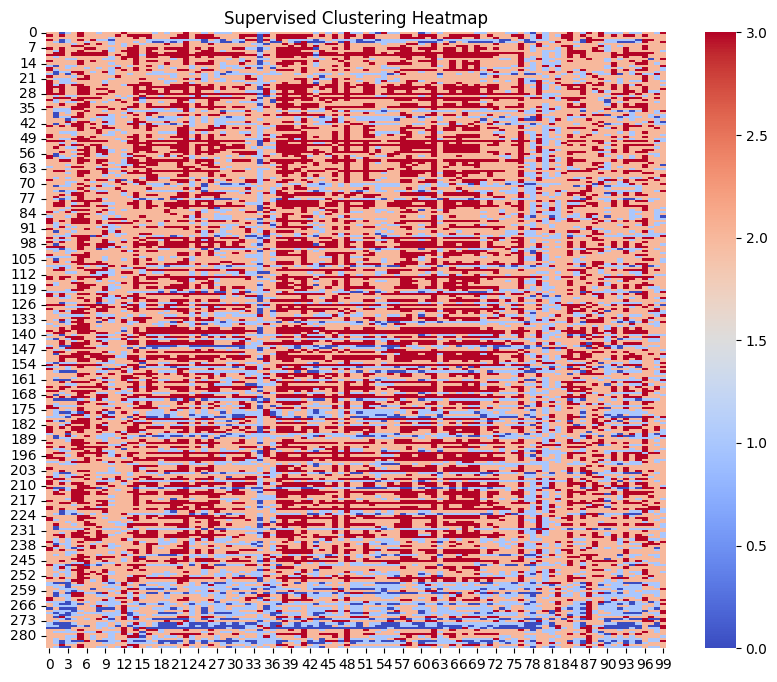

In [878]:
scaler = MinMaxScaler()
df = X_train.iloc[:, anova_features_index]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()

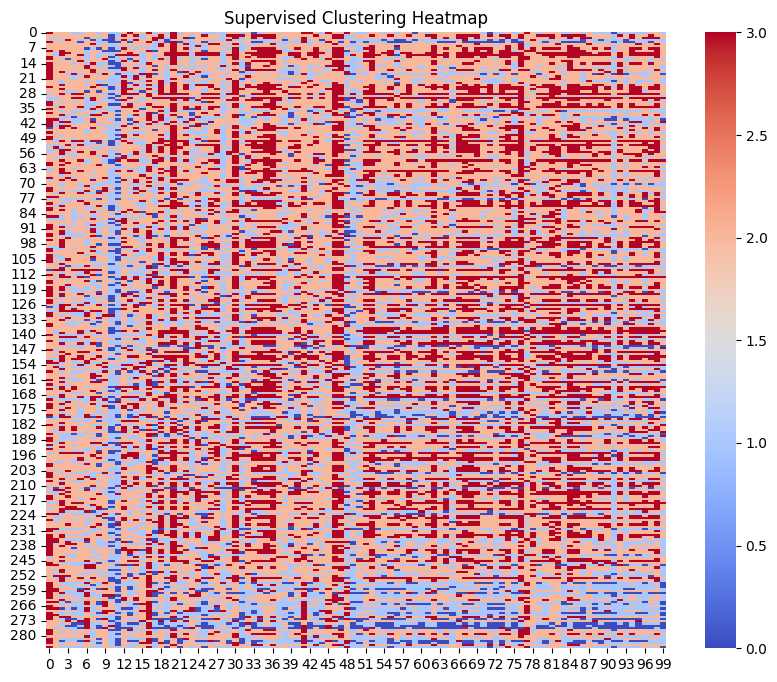

In [883]:
scaler = MinMaxScaler()
df = X_train.iloc[:, fdr_features_indices]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
#discretized_data = np.digitize(normalized_data, bins) - 1
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()

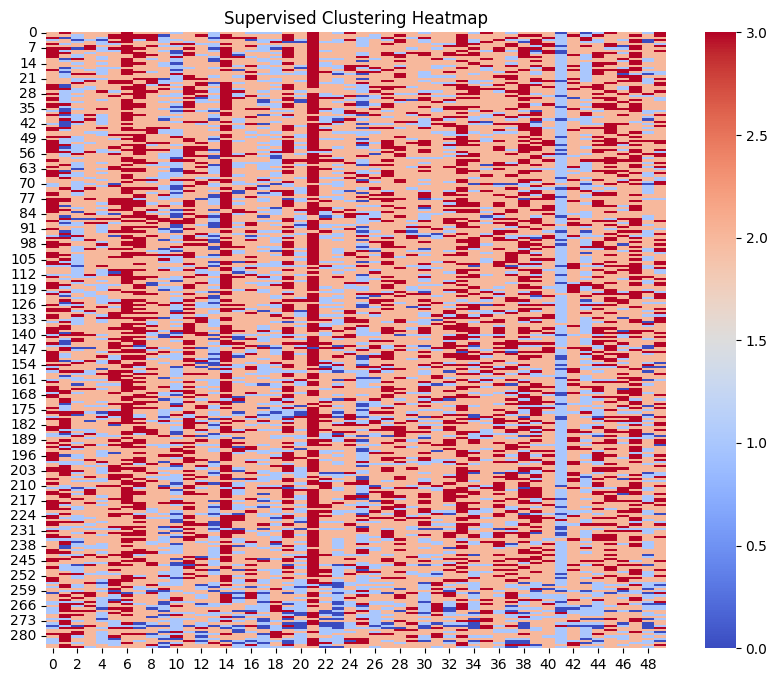

In [890]:
scaler = MinMaxScaler()
df = X_train.iloc[:, mrmr_index[:50]]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
#discretized_data = np.digitize(normalized_data, bins) - 1
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()

In [891]:
# Select features
X_train_selected = X_train.iloc[:, intersection_filters]
X_val_selected = X_val.iloc[:, intersection_filters]

# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Discretize the scaled data into bins
n_bins = 4
X_train_discretized = np.digitize(X_train_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])
X_val_discretized = np.digitize(X_val_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Train the logistic regression model
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)
model.fit(X_train_discretized, y_train)
y_pred = model.predict(X_val_discretized)

# Evaluate the model
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[27  5]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.29      0.50      0.36         4

    accuracy                           0.81        36
   macro avg       0.61      0.67      0.62        36
weighted avg       0.86      0.81      0.83        36



## Optimistic Genetic algorithm for the optimization of features selected


Ottimistica; usa LOO ma features selection è stata fatta su stessi dati X_train. Non possiamo avere davvero la certezza della generalizzabilità

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from deap import base, creator, tools, algorithms
import random
import numpy as np

# Assuming X_train_p and y_train_p are defined somewhere in your environment
X = X_train.iloc[:, anova_features_index]
y = y_train

# Custom function to generate the splits
def custom_leave_one_out_splits(X, y, n_splits=30, target_0=22, target_1=8):
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    np.random.shuffle(indices_0)
    np.random.shuffle(indices_1)
    
    splits = []
    
    for _ in range(n_splits):
        test_indices_0 = indices_0[:target_0]
        test_indices_1 = indices_1[:target_1]
        
        test_indices = np.concatenate((test_indices_0, test_indices_1))
        train_indices = np.array([i for i in range(len(y)) if i not in test_indices])
        
        splits.append((train_indices, test_indices))
        
        indices_0 = np.roll(indices_0, target_0)
        indices_1 = np.roll(indices_1, target_1)
    
    return splits

# Define evaluation function
def evaluate(individual):
    # Create a mask to select features
    selected_features = [bool(int(feature)) for feature in individual]
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_selected = X.iloc[:, selected_features]
    
    balanced_accuracies = []
    splits = custom_leave_one_out_splits(X_selected, y)
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    for train_index, val_index in splits:
        X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_val)
        
        balanced_acc = balanced_accuracy_score(y_val, y_pred)
        balanced_accuracies.append(balanced_acc)
    
    mean_balanced_acc = np.mean(balanced_accuracies)
    print(mean_balanced_acc)
    
    return mean_balanced_acc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('Best Individual:', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the balanced accuracy
balanced_acc = evaluate(best_individual)[0]
print('Balanced Accuracy of the Best Individual:', balanced_acc)


0.7428030303030302
0.7632575757575758
0.7119318181818183
0.7617424242424242
0.818371212121212
0.7835227272727271
0.7378787878787879
0.8024621212121212
0.7369318181818182
0.7253787878787878
0.7767045454545454
0.7356060606060605
0.7215909090909091
0.7464015151515152
0.7589015151515152
0.7388257575757575
0.6861742424242423
0.7369318181818181
0.7424242424242423
0.7333333333333333
gen	nevals
0  	20    
0.7554924242424242
0.7607954545454544
0.821590909090909
0.7912878787878787
0.793560606060606
0.7253787878787877
0.7450757575757575
0.8130681818181817
0.7751893939393939
0.7685606060606059
1  	10    
0.8051136363636363
0.7977272727272726
0.7505681818181817
0.7767045454545455
0.8441287878787878
0.8020833333333334
2  	6     
0.7926136363636364
0.8164772727272727
0.7649621212121211
0.7863636363636364
0.7956439393939393
0.7922348484848485
0.755871212121212
0.7916666666666665
0.809090909090909
0.7772727272727272
0.8232954545454544
0.8032196969696969
0.7981060606060607
3  	13    
0.7791666666666666


In [111]:
best_individual = [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]
mask = best_individual
ga_selected = [element for element, m in zip(anova_features_index, mask) if m]
ga_selected

[125,
 419,
 1028,
 1641,
 1746,
 1987,
 2379,
 2527,
 2615,
 3296,
 4118,
 4177,
 4559,
 4586,
 4839,
 5037,
 5733,
 6262,
 6705,
 7439,
 7778,
 7800,
 8732,
 8816,
 9209,
 9256,
 9340,
 9361,
 9412,
 9861,
 9994,
 10038,
 10131,
 10240,
 10376,
 10493,
 10522,
 10537,
 10841,
 10865,
 10976,
 11043,
 11114,
 11115,
 11210,
 11211,
 11254,
 11568,
 11657,
 11749,
 11872,
 11975,
 12006,
 12078,
 12099,
 12119,
 12373,
 12386,
 12466,
 12519,
 12534,
 12823,
 12920,
 13033,
 13410,
 13502,
 13531,
 13680,
 13882,
 14031,
 14101,
 14185,
 14336,
 14414,
 14714,
 14769,
 14778,
 15025,
 15159,
 15240,
 15754,
 16751,
 17075,
 17638,
 18011,
 18055,
 18081,
 18279,
 18313,
 18334,
 18422,
 18755,
 18837,
 18841,
 18885,
 19216,
 19684,
 19833,
 20076,
 20271,
 20345,
 20841,
 20845,
 20862,
 20864,
 20865,
 20868,
 20869,
 20870,
 20873,
 20876,
 20877,
 20878,
 20879,
 21082,
 21092,
 21095,
 21121,
 21203,
 21229,
 21267,
 21568,
 21884,
 21914,
 22056,
 22132,
 22206,
 22410,
 22443,
 

In [114]:
X_train

,1552426_a_at,1552846_s_at,1553678_a_at,1554556_a_at,1554701_a_at,1555016_at,1555540_at,1555755_at,1555870_at,1556924_at,...,242577_at,242817_at,244259_s_at,244485_at,244877_at,33768_at,36129_at,41644_at,41660_at,57532_at
GSM7501193,9.165935,9.996588,10.958735,8.193481,8.797671,10.047748,8.701805,6.552177,10.203533,8.496031,...,6.457200,8.816456,7.455335,9.113794,9.090602,11.730185,11.135478,11.411686,7.325045,10.454656
GSM7501091,9.988896,8.674136,8.108770,10.015552,8.438863,9.042767,6.936002,7.244820,8.531350,9.059777,...,6.370426,8.022512,8.530566,7.358115,6.598574,10.748975,10.715338,8.123185,7.808263,9.564529
GSM7500918,9.701826,8.700093,9.975705,8.789860,7.919459,9.583647,5.663914,3.857981,9.404077,8.263973,...,5.388878,6.871597,7.321928,8.193772,6.548437,9.849874,10.603812,8.457791,9.592083,9.931772
GSM7501216,9.292322,8.199672,11.518653,8.169925,8.076816,8.629357,6.442943,2.584963,9.784635,6.629357,...,4.643856,7.189825,5.700440,6.686501,7.888743,9.744834,10.641149,9.247928,7.826548,9.665336
GSM7501088,9.727920,10.456354,9.529431,8.238405,8.577429,8.103288,6.727920,4.643856,9.766529,6.794416,...,6.285402,6.977280,6.584963,8.108524,5.000000,10.406205,10.626622,10.336507,7.044394,10.166163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM7501056,9.659552,9.460294,10.567341,9.043722,9.324025,9.449260,6.141004,7.120559,11.075078,8.766141,...,5.962734,8.729706,8.684296,8.978699,8.702741,10.929391,10.880279,9.796852,8.591979,10.535963
GSM7501239,10.036860,9.568716,10.227496,9.810411,8.353588,8.900867,5.689299,4.754888,10.492554,8.193772,...,6.385431,8.496255,7.096979,8.688600,7.584963,10.156083,11.250180,10.113221,6.611763,10.219653
GSM7501146,8.826548,8.707359,10.603626,9.426265,8.771489,9.477758,5.285402,7.011227,10.585901,8.276124,...,5.954196,8.562242,7.686501,8.592457,5.857981,10.944712,11.501837,9.511753,7.936638,10.159871
GSM7501101,9.449149,9.124121,11.248521,7.672425,7.515700,8.599913,4.906891,7.139551,10.234817,8.787903,...,4.807355,7.066089,7.417853,6.807355,3.906891,10.452241,11.047124,8.625709,10.346514,10.194757


In [122]:
# Ensure best_features and ga_selected are lists
X = X_train.iloc[:, ga_selected]
y = y_train

# Initialize variables to store results
balanced_accuracies = []
confusion_matrix_total = np.zeros((2, 2), dtype=int)  # Explicit dtype
misclassified_indices = []

# Setup Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Perform LOO CV
for train_index, test_index in loo.split(X):
    X_train_f, X_test_f = X.iloc[train_index], X.iloc[test_index]
    y_train_f, y_test_f = y[train_index], y[test_index]
    
    # Manually apply scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_f)
    X_test_scaled = scaler.transform(X_test_f)

    # Fit the model
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_scaled, y_train_f)
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate confusion matrix and balanced accuracy for this fold
    cm = confusion_matrix(y_test_f, y_pred, labels=[0, 1])
    confusion_matrix_total += cm
    balanced_acc = balanced_accuracy_score(y_test_f, y_pred)
    balanced_accuracies.append(balanced_acc)

    # Print the final confusion matrix
print("Final Confusion Matrix:")
print(confusion_matrix_total)

# Optionally, you can print other metrics like the mean balanced accuracy
print("Mean Balanced Accuracy:", np.mean(balanced_accuracies))

# Calculate mean balanced accuracy

Final Confusion Matrix:
[[248   7]
 [  8  23]]
Mean Balanced Accuracy: 0.9475524475524476


In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from deap import base, creator, tools, algorithms
import random
import numpy as np

# Assuming X_train_p and y_train_p are defined somewhere in your environment
X = X_train.iloc[:, ga_selected]
y = y_train

# Custom function to generate the splits
def custom_leave_one_out_splits(X, y, n_splits=30, target_0=22, target_1=8):
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    np.random.shuffle(indices_0)
    np.random.shuffle(indices_1)
    
    splits = []
    
    for _ in range(n_splits):
        test_indices_0 = indices_0[:target_0]
        test_indices_1 = indices_1[:target_1]
        
        test_indices = np.concatenate((test_indices_0, test_indices_1))
        train_indices = np.array([i for i in range(len(y)) if i not in test_indices])
        
        splits.append((train_indices, test_indices))
        
        indices_0 = np.roll(indices_0, target_0)
        indices_1 = np.roll(indices_1, target_1)
    
    return splits

# Define evaluation function
def evaluate(individual):
    # Create a mask to select features
    selected_features = [bool(int(feature)) for feature in individual]
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_selected = X.iloc[:, selected_features]
    
    balanced_accuracies = []
    splits = custom_leave_one_out_splits(X_selected, y)
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    for train_index, val_index in splits:
        X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_val)
        
        balanced_acc = balanced_accuracy_score(y_val, y_pred)
        balanced_accuracies.append(balanced_acc)
    
    mean_balanced_acc = np.mean(balanced_accuracies)
    print(mean_balanced_acc)
    
    return mean_balanced_acc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('Best Individual:', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the balanced accuracy
balanced_acc = evaluate(best_individual)[0]
print('Balanced Accuracy of the Best Individual:', balanced_acc)


0.8145833333333333
0.8043560606060605
0.7579545454545454
0.7672348484848485
0.71875
0.8115530303030304
0.8045454545454546
0.730871212121212
0.7740530303030302
0.8071969696969695
0.8295454545454546
0.7835227272727272
0.805681818181818
0.7969696969696969
0.8107954545454545
0.7801136363636362
0.752651515151515
0.7986742424242423
0.7526515151515151
0.749810606060606
gen	nevals
0  	20    
0.7793560606060606
0.8035984848484847
0.8431818181818183
0.7871212121212121
0.8490530303030303
0.8071969696969695
0.749621212121212
0.7585227272727272
0.818560606060606
1  	9     
0.753219696969697
0.7765151515151516
0.8297348484848485
0.8229166666666666
0.8094696969696968
0.8356060606060605
0.8013257575757575
0.7946969696969696
0.7770833333333333
0.7859848484848484
0.7856060606060605
0.7971590909090909
0.840530303030303
0.7897727272727272
2  	14    
0.8214015151515152
0.8060606060606061
0.8018939393939395
0.8304924242424242
0.7767045454545454
0.8066287878787879
0.8356060606060606
0.8446969696969695
0.8060

In [145]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected])

# Fit the model
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))

[[30  2]
 [ 2  2]]


In [125]:
best_individual2 = [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
mask2 = best_individual2
ga_selected2 = [element for element, m in zip(ga_selected, mask) if m]
ga_selected2

[125,
 419,
 1028,
 2615,
 3296,
 4118,
 4177,
 4839,
 5037,
 5733,
 7439,
 7778,
 7800,
 8732,
 8816,
 9209,
 9340,
 9361,
 9994,
 10038,
 10240,
 10376,
 10522,
 10537,
 10841,
 10865,
 10976,
 11043,
 11114,
 11210,
 11568,
 11657,
 11975,
 12006,
 12078,
 12119,
 12373,
 12386,
 12466,
 12519,
 12823,
 12920,
 13033,
 13410,
 13502,
 13531,
 13882,
 14031,
 14185,
 14414,
 14714,
 14778,
 15025,
 15159,
 15240,
 15754,
 18055,
 18081,
 18279,
 18313,
 18334,
 18841,
 18885,
 19684,
 20841,
 20862,
 20865,
 20868,
 20873,
 20877,
 20879,
 21095,
 21121,
 21203,
 21267,
 21568,
 21884,
 21914,
 22056,
 22206,
 22410,
 22508,
 22561,
 22743,
 23096,
 23213,
 23975,
 24113,
 24635,
 24872,
 25337,
 25708,
 25763,
 26043,
 26173,
 26420,
 26503,
 26543,
 26552,
 27371,
 27387,
 27422,
 27710,
 27904,
 28303,
 28839,
 29058,
 29220,
 29349,
 31207,
 31635,
 32231,
 32378,
 33078,
 34020,
 34133,
 34168,
 34415,
 34770,
 34839,
 35378,
 35489,
 35953,
 36178,
 36234,
 36444,
 36781,
 3721

In [126]:
# Ensure best_features and ga_selected are lists
X = X_train.iloc[:, ga_selected2]
y = y_train

# Initialize variables to store results
balanced_accuracies = []
confusion_matrix_total = np.zeros((2, 2), dtype=int)  # Explicit dtype
misclassified_indices = []

# Setup Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Perform LOO CV
for train_index, test_index in loo.split(X):
    X_train_f, X_test_f = X.iloc[train_index], X.iloc[test_index]
    y_train_f, y_test_f = y[train_index], y[test_index]
    
    # Manually apply scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_f)
    X_test_scaled = scaler.transform(X_test_f)

    # Fit the model
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_scaled, y_train_f)
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate confusion matrix and balanced accuracy for this fold
    cm = confusion_matrix(y_test_f, y_pred, labels=[0, 1])
    confusion_matrix_total += cm
    balanced_acc = balanced_accuracy_score(y_test_f, y_pred)
    balanced_accuracies.append(balanced_acc)

    # Print the final confusion matrix
print("Final Confusion Matrix:")
print(confusion_matrix_total)

# Optionally, you can print other metrics like the mean balanced accuracy
print("Mean Balanced Accuracy:", np.mean(balanced_accuracies))

# Calculate mean balanced accuracy

Final Confusion Matrix:
[[243  12]
 [ 12  19]]
Mean Balanced Accuracy: 0.916083916083916


In [134]:
def b_score(y_true, y_pred, beta=1):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    if precision + recall == 0:
        return 0
    return (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

In [135]:
def make_b_score_scorer(beta):
    return make_scorer(b_score, beta=beta)

In [136]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight=)

# Definizione della grid search
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Parametro di regularizzazione
    'beta': [0.5, 1, 2]  # Valori di beta da provare
}

# Funzione per eseguire la grid search
def grid_search_with_beta(X_train, y_train, param_grid):
    best_score = -np.inf
    best_params = None

    for beta in param_grid['beta']:
        # Creazione di uno scorer basato sul b-score con il beta corrente
        b_score_scorer = make_b_score_scorer(beta)

        # Definizione della grid search per il beta corrente
        grid_search = GridSearchCV(model, {'C': param_grid['C']}, scoring=b_score_scorer, cv=LeaveOneOut(), n_jobs=-1)
        grid_search.fit(X_train, y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
            best_params['beta'] = beta

    return best_params, best_score

# Esecuzione della grid search
best_params, best_score = grid_search_with_beta(X_train.iloc[:, ga_selected], y_train, param_grid)

# Migliori parametri trovati dalla grid search
print("Migliori parametri trovati:", best_params)

Migliori parametri trovati: {'C': 11.288378916846883, 'beta': 0.5}


In [138]:
# Ensure best_features and ga_selected are lists
X = X_train.iloc[:, ga_selected]
y = y_train

# Initialize variables to store results
balanced_accuracies = []
confusion_matrix_total = np.zeros((2, 2), dtype=int)  # Explicit dtype
misclassified_indices = []

# Setup Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Perform LOO CV
for train_index, test_index in loo.split(X):
    X_train_f, X_test_f = X.iloc[train_index], X.iloc[test_index]
    y_train_f, y_test_f = y[train_index], y[test_index]
    
    # Manually apply scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_f)
    X_test_scaled = scaler.transform(X_test_f)

    # Fit the model
    clf = LogisticRegression(penalty='l1', solver = 'liblinear', C=11.288, class_weight='balanced')
    clf.fit(X_train_scaled, y_train_f)
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate confusion matrix and balanced accuracy for this fold
    cm = confusion_matrix(y_test_f, y_pred, labels=[0, 1])
    confusion_matrix_total += cm
    balanced_acc = balanced_accuracy_score(y_test_f, y_pred)
    balanced_accuracies.append(balanced_acc)

    # Print the final confusion matrix
print("Final Confusion Matrix:")
print(confusion_matrix_total)

# Optionally, you can print other metrics like the mean balanced accuracy
print("Mean Balanced Accuracy:", np.mean(balanced_accuracies))

# Calculate mean balanced accuracy

Final Confusion Matrix:
[[245  10]
 [  6  25]]
Mean Balanced Accuracy: 0.9440559440559441


In [144]:
y_pred = clf.predict(scaler.fit_transform(X_val.iloc[:, ga_selected]))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        32
           1       0.33      0.50      0.40         4

    accuracy                           0.83        36
   macro avg       0.63      0.69      0.65        36
weighted avg       0.87      0.83      0.85        36

[[28  4]
 [ 2  2]]


# GA

## Genetic Algorithm using Logistic Regression

### ANOVA, Genetic, LASSO

In [896]:

from sklearn.metrics import roc_auc_score, matthews_corrcoef
seed = 42
random.seed(seed)

# Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
X_train_f = X_train.iloc[:, anova_features_index]
X_val_f = X_val.iloc[:, anova_features_index]

# Define evaluation function with weighted accuracy based on probabilities
def evaluate(individual):
    # Create a mask to select features
    selected_features = np.array(individual).astype(bool)
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(roc_auc)
    
    return roc_auc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('best_individual = ', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the ROC AUC score
roc_auc = evaluate(best_individual)[0]
print('ROC AUC of the Best Individual:', roc_auc)


0.671875
0.6171875
0.625
0.6484375
0.5703125
0.640625
0.7109375
0.6484375
0.609375
0.53125
0.609375
0.5625
0.6484375
0.484375
0.5703125
0.7734375
0.640625
0.7265625
0.7890625
0.6796875
gen	nevals
0  	20    
0.7734375
0.6484375
0.703125
0.6171875
0.8046875
0.6328125
0.765625
0.6484375
0.78125
0.7109375
0.7734375
0.7265625
0.5859375
1  	13    
0.765625
0.7734375
0.8515625
0.6484375
0.65625
0.796875
0.7734375
0.7421875
0.7734375
0.71875
0.671875
0.7890625
0.6953125
0.7890625
0.6015625
0.7578125
0.7578125
2  	17    
0.7734375
0.7890625
0.6484375
0.734375
0.703125
0.8515625
0.703125
0.8515625
0.8125
0.8046875
0.7578125
0.7890625
0.7421875
0.78125
0.78125
3  	15    
0.765625
0.8125
0.8359375
0.8515625
0.8515625
0.7265625
0.7265625
0.796875
0.8203125
0.8125
0.78125
0.7578125
0.8359375
4  	13    
0.8515625
0.8515625
0.8828125
0.8515625
0.84375
0.8359375
0.828125
0.734375
0.8515625
0.8515625
0.84375
0.8515625
0.859375
0.8046875
5  	14    
0.84375
0.8515625
0.84375
0.8515625
0.8515625
0.7890625


In [897]:
best_individual =  [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
mask_anova = best_individual
ga_selected_anova = [element for element, m in zip(anova_features_index, mask_anova) if m]
ga_selected_anova

[7439,
 7440,
 9256,
 12078,
 12747,
 19833,
 20866,
 20868,
 20869,
 20878,
 20879,
 21019,
 21056,
 21082,
 21095,
 21121,
 22695,
 23975,
 24170,
 24815,
 24971,
 25399,
 25592,
 25621,
 25682,
 25701,
 25708,
 25731,
 25732,
 25750,
 25766,
 26036,
 26043,
 26272,
 26331,
 26334,
 26343,
 26365,
 26412,
 26421,
 26441,
 26543,
 26561,
 26663,
 26992,
 27075,
 31931,
 32804,
 33493,
 34962,
 41658,
 43531,
 43871,
 44411]

In [908]:
X_train_selected = X_train.iloc[:, ga_selected_anova]
X_val_selected = X_val.iloc[:, ga_selected_anova]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.8671875
[[29  3]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.50      0.75      0.60         4

    accuracy                           0.89        36
   macro avg       0.73      0.83      0.77        36
weighted avg       0.91      0.89      0.90        36



In [494]:
list(X.columns[ga_selected_anova])

['1552426_a_at',
 '1553715_s_at',
 '1554258_a_at',
 '1554556_a_at',
 '1555016_at',
 '1555870_at',
 '1558176_at',
 '1558327_at',
 '1558438_a_at',
 '1561122_a_at',
 '1562624_at',
 '1562703_at',
 '1569551_at',
 '1569765_at',
 '1569872_a_at',
 '1729_at',
 '200005_at',
 '200877_at',
 '201160_s_at',
 '201175_at',
 '201479_at',
 '201573_s_at',
 '201681_s_at',
 '201752_s_at',
 '201753_s_at',
 '201848_s_at',
 '201892_s_at',
 '202207_at',
 '202599_s_at',
 '202613_at',
 '202644_s_at',
 '202737_s_at',
 '202757_at',
 '202786_at',
 '202862_at',
 '202931_x_at',
 '203010_at',
 '203023_at',
 '203103_s_at',
 '203172_at',
 '203200_s_at',
 '203386_at',
 '203462_x_at',
 '203559_s_at',
 '203719_at',
 '204042_at',
 '204049_s_at',
 '204153_s_at',
 '204170_s_at',
 '204319_s_at',
 '204393_s_at',
 '204670_x_at',
 '204724_s_at',
 '204780_s_at',
 '204781_s_at',
 '205355_at',
 '205419_at',
 '205845_at',
 '205882_x_at',
 '206398_s_at',
 '207011_s_at',
 '208165_s_at',
 '208308_s_at',
 '208758_at',
 '208956_x_at',
 '2

In [163]:
from sklearn.metrics import make_scorer, fbeta_score

In [310]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_anova])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_anova])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[27  5]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        32
           1       0.38      0.75      0.50         4

    accuracy                           0.83        36
   macro avg       0.67      0.80      0.70        36
weighted avg       0.90      0.83      0.86        36



In [ ]:
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_anova])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

In [311]:
lasso_selected = np.nonzero(model.coef_)[1]

In [312]:
X_train.iloc[:, ga_selected_anova].columns[lasso_selected]

Index(['1562703_at', '202207_at', '202644_s_at', '202931_x_at', '203172_at',
       '203462_x_at', '204042_at', '204153_s_at', '204393_s_at', '205355_at',
       '205882_x_at', '209434_s_at', '210538_s_at', '211965_at', '213489_at',
       '214371_at', '216488_s_at', '217390_x_at', '218204_s_at', '218722_s_at',
       '221479_s_at', '222034_at', '222173_s_at', '223995_at', '225822_at',
       '226098_at', '227097_at', '228423_at', '229647_at', '230106_at',
       '232766_at', '233855_at', '234284_at', '234353_at', '238662_at',
       '242277_at', '36564_at'],
      dtype='object')

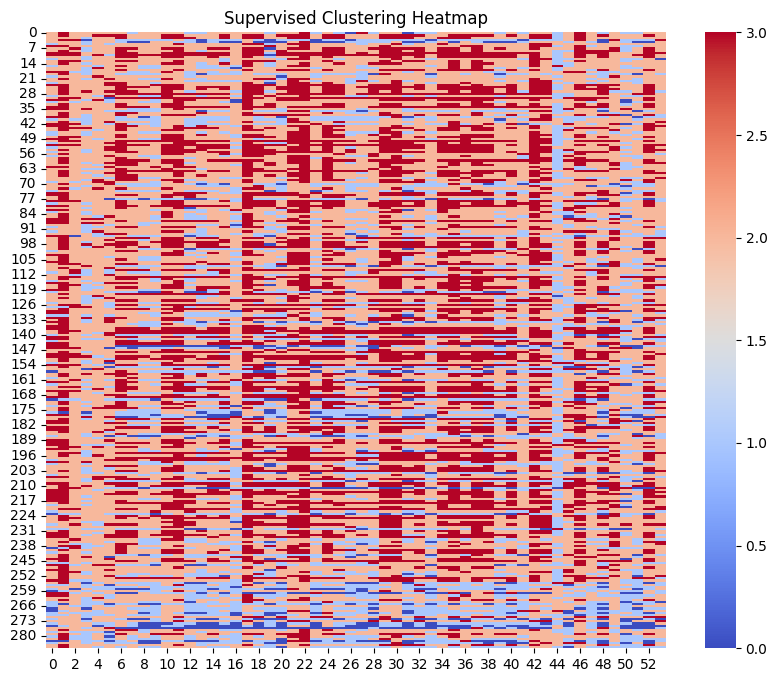

In [911]:
scaler = MinMaxScaler()
df = X_train.iloc[:, ga_selected_anova]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()

### FDR, Genetic, LASSO

In [912]:
# ANOVA, GA based on AUC ROC, LASSO

from sklearn.metrics import roc_auc_score
seed = 42
random.seed(seed)
# Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
X_train_f = X_train.iloc[:, fdr_features_indices]
X_val_f = X_val.iloc[:, fdr_features_indices]
y_train = y_train
y_val = y_val

# Define evaluation function with weighted accuracy based on probabilities
def evaluate(individual):
    # Create a mask to select features
    selected_features = np.array(individual).astype(bool)
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(roc_auc)
    
    return roc_auc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('best_individual =', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the ROC AUC score
roc_auc = evaluate(best_individual)[0]
print('ROC AUC of the Best Individual:', roc_auc)

0.796875
0.3828125
0.7734375
0.46875
0.609375
0.640625
0.671875
0.6171875
0.6875
0.5
0.609375
0.5
0.765625
0.6171875
0.6171875
0.671875
0.4375
0.7421875
0.6640625
0.5234375
gen	nevals
0  	20    
0.7421875
0.625
0.578125
0.71875
0.7734375
0.7734375
0.765625
0.609375
0.5625
0.671875
0.671875
0.828125
0.6953125
1  	13    
0.7734375
0.7734375
0.875
0.609375
0.7421875
0.703125
0.6875
0.75
0.78125
0.7890625
0.78125
0.7890625
0.84375
0.71875
0.6875
0.7734375
0.7890625
2  	17    
0.671875
0.828125
0.6796875
0.7734375
0.828125
0.8359375
0.8125
0.875
0.734375
0.765625
0.7734375
0.765625
0.8125
0.7734375
0.7890625
3  	15    
0.875
0.7734375
0.890625
0.8515625
0.875
0.8828125
0.8125
0.8828125
0.71875
0.828125
0.8359375
0.9140625
0.8515625
4  	13    
0.8671875
0.8671875
0.9140625
0.828125
0.84375
0.90625
0.8671875
0.875
0.8828125
0.9140625
0.8671875
0.8828125
0.8828125
0.8828125
5  	14    
0.8984375
0.8828125
0.84375
0.8828125
0.9140625
0.8515625
0.9140625
0.8984375
0.890625
0.765625
6  	10    
0.9

In [913]:

best_individual = [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]
mask_fdr = best_individual
ga_selected_fdr = [element for element, m in zip(fdr_features_indices, mask_fdr) if m]
ga_selected_fdr

[11657,
 46559,
 51000,
 32432,
 21588,
 21202,
 35626,
 25763,
 21092,
 26464,
 7439,
 46521,
 25143,
 21203,
 26036,
 20866,
 21019,
 32804,
 12078,
 2492,
 25731,
 18340,
 26543,
 23975,
 26334,
 20868,
 26365,
 26272,
 24815,
 26503,
 26441,
 25603,
 20869,
 20871,
 22695,
 23966,
 26412,
 4054,
 43531,
 24113,
 21082,
 26552,
 20879,
 43958,
 26420,
 43871,
 20884,
 25732,
 43991,
 43480,
 25701,
 26331,
 6262]

In [914]:
X_train_selected = X_train.iloc[:, ga_selected_fdr]
X_val_selected = X_val.iloc[:, ga_selected_fdr]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.953125
[[27  5]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        32
           1       0.38      0.75      0.50         4

    accuracy                           0.83        36
   macro avg       0.67      0.80      0.70        36
weighted avg       0.90      0.83      0.86        36



In [351]:
list(X_train.columns[ga_selected_fdr])

['234814_at',
 '218552_at',
 '211548_s_at',
 '226133_s_at',
 '225291_at',
 '218075_at',
 '1564362_x_at',
 '1561140_at',
 '208828_at',
 '203565_s_at',
 '227484_at',
 '1557276_at',
 '225553_at',
 '226763_at',
 '212940_at',
 '204049_s_at',
 '1555737_a_at',
 '211050_x_at',
 '226116_at',
 '1562681_at',
 '237037_at',
 '234422_at',
 '226839_at',
 '1556417_a_at',
 '214465_at',
 '235870_at',
 '218767_at',
 '218220_at',
 '224369_s_at',
 '203200_s_at',
 '221494_x_at',
 '1557388_at',
 '1569765_at',
 '225358_at',
 '227947_at',
 '210136_at',
 '225418_at',
 '211405_x_at',
 '213750_at',
 '227307_at',
 '218010_x_at',
 '226351_at',
 '225589_at',
 '201860_s_at',
 '200690_at',
 '203576_at',
 '224579_at',
 '209318_x_at',
 '211962_s_at',
 '209100_at',
 '240260_at',
 '227477_at',
 '201479_at',
 '224623_at',
 '226882_x_at',
 '213919_at',
 '207011_s_at',
 '238116_at',
 '241446_at',
 '237752_at',
 '202309_at',
 '210792_x_at',
 '1552889_a_at',
 '225143_at',
 '203172_at',
 '212145_at',
 '212018_s_at',
 '218548_x_

In [915]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_fdr])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_fdr])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
lasso_selected = np.nonzero(model.coef_)[1]
X_train.iloc[:, ga_selected_fdr].columns[lasso_selected]

[[25  7]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        32
           1       0.30      0.75      0.43         4

    accuracy                           0.78        36
   macro avg       0.63      0.77      0.65        36
weighted avg       0.89      0.78      0.81        36



Index(['241937_s_at', '223266_at', '226488_at', '1564154_at', '237423_at',
       '211991_s_at', '202716_at', '1555711_x_at', '213489_at', '217145_at',
       '1561937_x_at'],
      dtype='object')

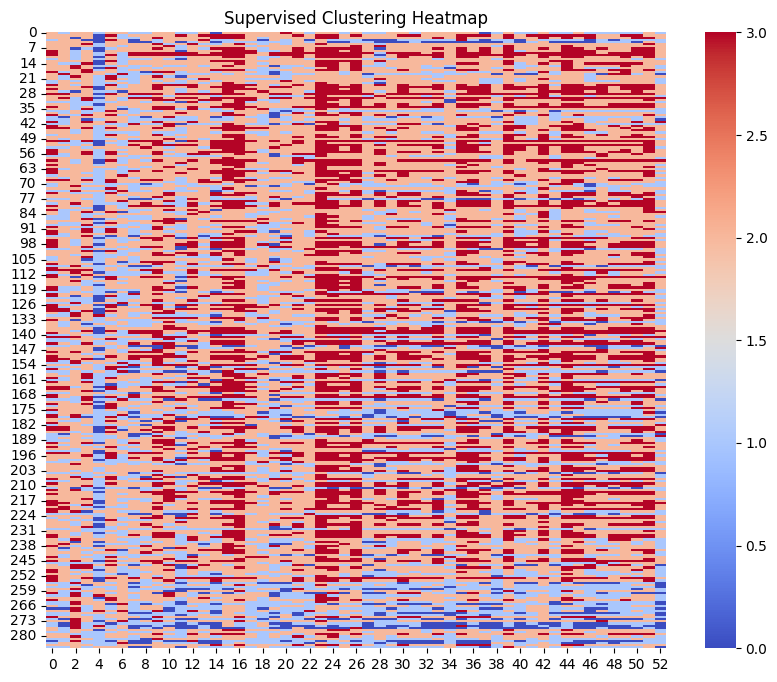

In [925]:
scaler = MinMaxScaler()
df = X_train.iloc[:, ga_selected_fdr]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()

### mRMR, Genetic, LASSO

In [243]:
from sklearn.metrics import roc_auc_score
seed = 42
random.seed(seed)
# Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
X_train_f = X_train.iloc[:, mrmr_index]
X_val_f = X_val.iloc[:, mrmr_index]
y_train = y_train
y_val = y_val

# Define evaluation function with weighted accuracy based on probabilities
def evaluate(individual):
    # Create a mask to select features
    selected_features = np.array(individual).astype(bool)
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(roc_auc)
    
    return roc_auc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('Best Individual:', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the ROC AUC score
roc_auc = evaluate(best_individual)[0]
print('ROC AUC of the Best Individual:', roc_auc)

0.609375
0.609375
0.5859375
0.71875
0.7421875
0.6015625
0.5859375
0.609375
0.671875
0.7265625
0.5625
0.609375
0.65625
0.7421875
0.65625
0.6328125
0.6953125
0.5546875
0.6171875
0.6171875
gen	nevals
0  	20    
0.71875
0.59375
0.640625
0.5703125
0.6484375
0.7109375
0.65625
0.59375
0.6640625
0.7421875
0.7265625
0.6875
0.640625
1  	13    
0.71875
0.734375
0.7265625
0.765625
0.7421875
0.7265625
0.7265625
0.7265625
0.671875
2  	9     
0.671875
0.7421875
0.7421875
0.734375
0.6953125
0.703125
0.7421875
0.734375
0.734375
0.7421875
0.7421875
3  	11    
0.7421875
0.7421875
0.75
0.7421875
0.703125
0.6796875
0.75
0.7109375
0.7421875
0.7421875
0.6953125
0.7421875
0.7421875
0.7421875
4  	14    
0.7265625
0.7421875
0.7421875
0.7421875
0.7421875
0.7421875
0.765625
0.7421875
0.75
0.75
5  	10    
0.75
0.75
0.71875
0.6484375
0.7265625
6  	5     
0.75
0.6796875
0.765625
0.75
0.75
0.75
0.7421875
0.75
0.7421875
0.71875
7  	10    
0.7578125
0.734375
0.75
0.75
0.75
0.75
0.765625
0.765625
0.75
0.7578125
8  	10  

In [246]:
best_individual = [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]
mask_mrmr = best_individual
ga_selected_mrmr = [element for element, m in zip(mrmr_index, mask_mrmr) if m]
ga_selected_mrmr


[4586,
 12078,
 37212,
 47510,
 6705,
 7800,
 14769,
 11569,
 41658,
 33155,
 6262,
 27735,
 30173,
 26019,
 37082,
 21056,
 13514,
 34962,
 43871,
 43508,
 34415,
 38389,
 43467,
 43480,
 21914,
 16079,
 44179,
 26567,
 39629,
 43399,
 12747,
 13882,
 16751,
 41597,
 45627,
 27259,
 22132,
 26334,
 37225,
 24371,
 24635,
 35244,
 9256,
 21177,
 43991,
 31682,
 13754,
 37606,
 51339,
 27421,
 43386,
 12920,
 54043,
 25603,
 11210,
 24737,
 25750,
 51606,
 50811,
 35199,
 26543,
 12006,
 27387,
 1746,
 29220,
 13410,
 20874,
 24170,
 9361,
 40972,
 18334,
 35728,
 26573,
 12904,
 40001,
 33166,
 29334,
 35900,
 26365,
 34114,
 54183,
 34133,
 53309,
 12294,
 22743,
 23122,
 1338,
 25143,
 26203,
 7623,
 48224,
 419,
 21967,
 21019,
 15430,
 34839,
 18340,
 26441,
 15761,
 18828,
 21202,
 51105,
 27271,
 43958,
 26945,
 46152,
 23572,
 40261,
 22140,
 36190,
 5748,
 10235,
 20866,
 1422,
 7671,
 8284,
 25337,
 28303,
 22056,
 12005,
 1641,
 21092,
 30854,
 2379,
 13080,
 35626,
 8136,
 1

In [253]:
X_train_selected = X_train.iloc[:, ga_selected_mrmr]
X_val_selected = X_val.iloc[:, ga_selected_mrmr]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))



0.8046875
[[31  1]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.67      0.50      0.57         4

    accuracy                           0.92        36
   macro avg       0.80      0.73      0.76        36
weighted avg       0.91      0.92      0.91        36



In [348]:
list(X_train.columns[ga_selected_mrmr])

['1559139_at',
 '202716_at',
 '228077_at',
 '238417_at',
 '1562703_at',
 '1565535_x_at',
 '205410_s_at',
 '202207_at',
 '232531_at',
 '223995_at',
 '1561937_x_at',
 '218552_at',
 '220994_s_at',
 '216829_at',
 '227947_at',
 '211835_at',
 '204153_s_at',
 '225822_at',
 '234764_x_at',
 '234396_at',
 '225275_at',
 '229256_at',
 '234353_at',
 '234366_x_at',
 '212704_at',
 '206723_s_at',
 '235072_s_at',
 '217384_x_at',
 '230499_at',
 '234284_at',
 '203386_at',
 '204521_at',
 '207399_at',
 '232470_at',
 '236525_at',
 '218076_s_at',
 '212923_s_at',
 '217148_x_at',
 '228090_at',
 '215176_x_at',
 '215440_s_at',
 '226105_at',
 '1569629_x_at',
 '211965_at',
 '234884_x_at',
 '222512_at',
 '204393_s_at',
 '228471_at',
 '242277_at',
 '218238_at',
 '234271_at',
 '203559_s_at',
 '36564_at',
 '216412_x_at',
 '201848_s_at',
 '215543_s_at',
 '216560_x_at',
 '242546_at',
 '241747_s_at',
 '226060_at',
 '217360_x_at',
 '202644_s_at',
 '218204_s_at',
 '1554701_a_at',
 '220040_x_at',
 '204049_s_at',
 '211645_x_

In [320]:

model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.5)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_mrmr])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_mrmr])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
lasso_selected = np.nonzero(model.coef_)[1]
X_train.iloc[:, ga_selected_mrmr].columns[lasso_selected]

[[29  3]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.50      0.75      0.60         4

    accuracy                           0.89        36
   macro avg       0.73      0.83      0.77        36
weighted avg       0.91      0.89      0.90        36



Index(['1559139_at', '202716_at', '228077_at', '238417_at', '1562703_at',
       '1565535_x_at', '205410_s_at', '232531_at', '223995_at', '218552_at',
       '220994_s_at', '227947_at', '204153_s_at', '225822_at', '234396_at',
       '225275_at', '206723_s_at', '234284_at', '232470_at', '218076_s_at',
       '228090_at', '226105_at', '228471_at', '242546_at', '202644_s_at',
       '231843_at', '203543_s_at', '230871_at', '224006_at', '220154_at',
       '41660_at', '202931_x_at', '213919_at', '217014_s_at', '206073_at',
       '227053_at', '1561140_at', '216145_at', '1554556_a_at', '221679_s_at',
       '36019_at', '208991_at', '205055_at', '204319_s_at', '219336_s_at',
       '228476_at', '233896_s_at', '1553241_at', '1557248_at', '232766_at',
       '220169_at', '205570_at', '210432_s_at', '240587_x_at', '204042_at',
       '218653_at', '210587_at', '1558581_at', '227097_at', '1557360_at',
       '228454_at', '1569542_at', '242045_at', '210479_s_at', '236224_at',
       '203199_s_at'

### Relief, Gen, LASSO

In [268]:
# ANOVA, GA based on AUC ROC, LASSO

from sklearn.metrics import roc_auc_score
seed = 42
random.seed(seed)
# Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
X_train_f = X_train.iloc[:, relief_feature_indices]
X_val_f = X_val.iloc[:, relief_feature_indices]
y_train = y_train
y_val = y_val

# Define evaluation function with weighted accuracy based on probabilities
def evaluate(individual):
    # Create a mask to select features
    selected_features = np.array(individual).astype(bool)
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(roc_auc)
    
    return roc_auc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('best_individual =', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the ROC AUC score
roc_auc = evaluate(best_individual)[0]
print('ROC AUC of the Best Individual:', roc_auc)

0.8046875
0.5859375
0.640625
0.65625
0.546875
0.7265625
0.5703125
0.5234375
0.484375
0.625
0.671875
0.6171875
0.625
0.5625
0.703125
0.609375
0.6015625
0.546875
0.484375
0.484375
gen	nevals
0  	20    
0.6484375
0.6875
0.6484375
0.7421875
0.625
0.5859375
0.734375
0.6796875
0.5546875
0.5703125
0.640625
0.59375
0.625
1  	13    
0.6328125
0.796875
0.78125
0.6171875
0.7421875
0.734375
0.5859375
0.75
0.6171875
2  	9     
0.75
0.875
0.7421875
0.7578125
0.5859375
0.625
0.8046875
0.6640625
0.7109375
0.8359375
0.71875
3  	11    
0.7421875
0.84375
0.765625
0.8359375
0.7265625
0.8359375
0.8046875
0.828125
0.8046875
0.8046875
0.75
0.8046875
0.78125
0.8046875
4  	14    
0.8125
0.828125
0.8046875
0.8359375
0.8359375
0.8125
0.8046875
0.75
0.8359375
0.8359375
5  	10    
0.828125
0.8203125
0.8515625
0.84375
0.8046875
6  	5     
0.8359375
0.8359375
0.8359375
0.8359375
0.8125
0.8515625
0.765625
0.8046875
0.890625
0.8203125
7  	10    
0.8515625
0.796875
0.8046875
0.890625
0.890625
0.7578125
0.84375
0.84375


In [269]:
best_individual = [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
mask_relief = best_individual
ga_selected_relief = [element for element, m in zip(relief_feature_indices, mask_relief) if m]
ga_selected_relief

[3973,
 3457,
 30431,
 5664,
 8949,
 39947,
 7151,
 43063,
 9503,
 42941,
 47173,
 51434,
 25291,
 30894,
 8654,
 50949,
 43428,
 4074,
 8618,
 26290,
 53017,
 37815,
 35122,
 3185,
 45420,
 50860,
 14912,
 5104,
 57,
 30005,
 7578,
 1910,
 16655,
 25757,
 30016,
 11012,
 30594,
 13829,
 24387,
 39987,
 47436,
 45046,
 44787,
 23506,
 53459,
 52162,
 31705,
 7252,
 19745,
 16495,
 15558,
 19934,
 533,
 42864,
 9736,
 29389,
 20556,
 50635,
 30111,
 25615,
 3748,
 8952,
 8703,
 53273,
 3935,
 34651,
 47124,
 13127,
 49654,
 16730,
 3332,
 5276,
 40703,
 43910,
 22968,
 15343,
 723,
 26288,
 48209,
 8497,
 16240,
 53790,
 43450,
 46375,
 44586,
 46504,
 16308,
 3698,
 50345,
 43886,
 12900,
 4905,
 7660,
 48081,
 26021,
 5663,
 15557,
 30295,
 6432,
 1527,
 24708,
 25308,
 15498,
 21009,
 29719,
 19735,
 43940,
 5005,
 17262,
 43621,
 45438,
 5427,
 43571,
 9248,
 43524,
 50377,
 50406,
 38299,
 20960,
 8177,
 23776,
 25516,
 6898,
 22560,
 26124,
 40868,
 7149,
 5573,
 30752,
 2565,
 19

In [325]:
X_train_selected = X_train.iloc[:, ga_selected_relief]
X_val_selected = X_val.iloc[:, ga_selected_relief]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.96875
[[30  2]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.60      0.75      0.67         4

    accuracy                           0.92        36
   macro avg       0.78      0.84      0.81        36
weighted avg       0.93      0.92      0.92        36



In [346]:
list(X_train.columns[ga_selected_relief])

['1557991_at',
 '1557180_at',
 '221254_s_at',
 '1561025_at',
 '1569097_at',
 '230817_at',
 '1563462_at',
 '233947_s_at',
 '1570023_at',
 '233821_at',
 '238080_at',
 '242372_s_at',
 '216099_at',
 '221721_s_at',
 '1568287_at',
 '241886_x_at',
 '234313_at',
 '1558216_at',
 '1567657_at',
 '217103_at',
 '243965_at',
 '228681_x_at',
 '225983_s_at',
 '1556759_at',
 '236318_x_at',
 '241796_x_at',
 '205553_s_at',
 '1560062_at',
 '1552321_a_at',
 '220825_s_at',
 '1564460_at',
 '1554912_at',
 '207302_at',
 '216567_at',
 '220837_at',
 '201650_at',
 '221417_x_at',
 '204468_s_at',
 '215192_at',
 '230857_s_at',
 '238343_x_at',
 '235944_at',
 '235682_s_at',
 '214304_x_at',
 '244410_at',
 '243106_at',
 '222535_at',
 '1563660_at',
 '210439_at',
 '207140_at',
 '206202_at',
 '210642_at',
 '1553009_s_at',
 '233743_x_at',
 '1570391_at',
 '220209_at',
 '211307_s_at',
 '241567_at',
 '220932_at',
 '216424_at',
 '1557636_a_at',
 '1569100_a_at',
 '1568643_a_at',
 '244223_at',
 '1557891_s_at',
 '225511_at',
 '238

In [328]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_relief])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_relief])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
lasso_selected = np.nonzero(model.coef_)[1]
X_train.iloc[:, ga_selected_relief].columns[lasso_selected]

[[29  3]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.50      0.75      0.60         4

    accuracy                           0.89        36
   macro avg       0.73      0.83      0.77        36
weighted avg       0.91      0.89      0.90        36



Index(['1561025_at', '230817_at', '233821_at', '242372_s_at', '221721_s_at',
       '1568287_at', '234313_at', '1558216_at', '1556759_at', '236318_x_at',
       '241796_x_at', '220825_s_at', '1554912_at', '201650_at', '204468_s_at',
       '211307_s_at', '216424_at', '1568643_a_at', '1556980_at', '1560380_at',
       '1553266_at', '217101_at', '239120_at', '1567030_at', '206884_s_at',
       '244742_at', '234336_s_at', '237277_at', '1559686_a_at', '206201_s_at',
       '216116_at', '220539_at', '1560643_x_at', '234460_at', '241306_at',
       '241335_at', '229166_s_at', '213354_s_at', '216935_at', '231739_at',
       '210121_at', '1557713_at', '233751_at', '205358_at', '232074_at',
       '235910_x_at', '215296_at', '238112_at', '1562320_at', '210562_at',
       '220269_at', '229639_s_at', '1562139_a_at', '234029_at', '214981_at',
       '231089_at', '229973_at', '239639_at', '207177_at', '229259_at',
       '243087_at', '1569378_at', '230317_x_at', '240724_at', '226953_at',
       '15

### IG, Genetic, LASSO

In [583]:
# ANOVA, GA based on AUC ROC, LASSO

from sklearn.metrics import roc_auc_score
seed = 42
random.seed(seed)
# Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
X_train_f = X_train.iloc[:, ig_features_index]
X_val_f = X_val.iloc[:, ig_features_index]

# Define evaluation function with weighted accuracy based on probabilities
def evaluate(individual):
    # Create a mask to select features
    selected_features = np.array(individual).astype(bool)
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(roc_auc)
    
    return roc_auc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('best_individual =', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the ROC AUC score
roc_auc = evaluate(best_individual)[0]
print('ROC AUC of the Best Individual:', roc_auc)

0.7578125
0.6640625
0.65625
0.5859375
0.8203125
0.53125
0.59375
0.5859375
0.6796875
0.6484375
0.6171875
0.75
0.6640625
0.8515625
0.671875
0.5859375
0.671875
0.6484375
0.484375
0.796875
gen	nevals
0  	20    
0.8359375
0.65625
0.671875
0.671875
0.796875
0.828125
0.8125
0.765625
0.734375
0.8828125
0.7421875
0.796875
0.8203125
1  	13    
0.796875
0.8046875
0.890625
0.7109375
0.6953125
0.7578125
0.796875
0.8515625
0.796875
2  	9     
0.7890625
0.8515625
0.8515625
0.75
0.8515625
0.8671875
0.8125
0.875
0.765625
0.8828125
0.8828125
3  	11    
0.8828125
0.890625
0.875
0.8828125
0.7734375
0.8828125
0.8828125
0.875
0.8515625
0.8828125
0.875
0.8828125
0.90625
0.8359375
4  	14    
0.8046875
0.8671875
0.75
0.90625
0.90625
0.890625
0.875
0.8515625
0.8828125
0.8828125
5  	10    
0.828125
0.875
0.859375
0.8828125
0.8203125
6  	5     
0.890625
0.890625
0.90625
0.890625
0.8828125
0.8828125
0.8515625
0.875
0.8515625
0.8203125
7  	10    
0.84375
0.9140625
0.828125
0.90625
0.890625
0.8515625
0.90625
0.90625

In [584]:
best_individual = [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
mask_ig = best_individual
ga_selected_ig = [element for element, m in zip(ig_features_index, mask_ig) if m]

In [558]:
X_train_selected = X_train.iloc[:, ga_selected_ig]
X_val_selected = X_val.iloc[:, ga_selected_ig]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9609375
[[31  1]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.75      0.75      0.75         4

    accuracy                           0.94        36
   macro avg       0.86      0.86      0.86        36
weighted avg       0.94      0.94      0.94        36



In [561]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_ig])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_ig])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
lasso_selected = np.nonzero(model.coef_)[1]
X_train.iloc[:, ga_selected_ig].columns[lasso_selected]

[[28  4]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36



Index(['1553114_a_at', '1553180_at', '1554210_at', '1554440_at', '1555907_at',
       '1563549_a_at', '1564155_x_at', '1564242_at', '1564937_at',
       '1565535_x_at', '1565694_at', '1565838_at', '1568730_at', '1570601_at',
       '200843_s_at', '200865_at', '202207_at', '202387_at', '202878_s_at',
       '203181_x_at', '203559_s_at', '204083_s_at', '205139_s_at',
       '205625_s_at', '206595_at', '206616_s_at', '207530_s_at', '208019_at',
       '208261_x_at', '208688_x_at', '210070_s_at', '210427_x_at', '211648_at',
       '211650_x_at', '212064_x_at', '212065_s_at', '212674_s_at', '213262_at',
       '213674_x_at', '213900_at', '215573_at', '215868_x_at', '216525_x_at',
       '216934_at', '217082_at', '217421_at', '217790_s_at', '218238_at',
       '218552_at', '219279_at', '219529_at', '219585_at', '219772_s_at',
       '220132_s_at', '220338_at', '220618_s_at', '221903_s_at', '222900_at',
       '223786_at', '224265_s_at', '224339_s_at', '225630_at', '227677_at',
       '228641

## Genetic Alorithm with KLogistic Regression and Lasso

In [579]:
seed = 42
random.seed(seed)

for feature_set in [anova_features_index, fdr_features_indices, mrmr_index, relief_feature_indices, ig_features_index]:
    filtered_feature_indices = feature_set
    # Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
    X_train_f = X_train.iloc[:, filtered_feature_indices]
    X_val_f = X_val.iloc[:, filtered_feature_indices]

    # Define evaluation function with weighted accuracy based on probabilities
    def evaluate(individual):
        # Create a mask to select features
        selected_features = np.array(individual).astype(bool)
        
        if sum(selected_features) == 0:
            return 0,  # Avoid having no features selected
        
        X_train_selected = X_train_f.iloc[:, selected_features]
        X_val_selected = X_val_f.iloc[:, selected_features]
        
        # Using a pipeline to incorporate scaling and logistic regression
        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
        ])
        
        pipe.fit(X_train_selected, y_train)
        y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
        
        # Calculate weighted accuracy based on probabilities
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        print(roc_auc)
        
        return roc_auc,

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Run the Genetic Algorithm
    population = toolbox.population(n=20)
    ngen = 20
    cxpb = 0.5
    mutpb = 0.2

    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

    # Extract the best individual
    best_individual = tools.selBest(population, 1)[0]
    print('Best Individual:', best_individual)
    print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

    # Evaluate the best individual to print the custom fitness score
    mask_selected = best_individual
    ga_selected_filtered = [element for element, m in zip(filtered_feature_indices, mask_selected) if m]

    X_train_selected = X_train.iloc[:, ga_selected_filtered]
    X_val_selected = X_val.iloc[:, ga_selected_filtered]

    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced'))
    ])

    pipe.fit(X_train_selected, y_train)
    y_pred = pipe.predict(X_val_selected)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
        
        # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    # Calculate ROC AUC score
    print("Classification with features selected by the GA")
    print(f'ROC AUC: {roc_auc}')
    print(confusion_matrix(y_val, y_pred))

        # print(classification_report(y_val, y_pred))

    # # Logistic regression with L1 regularization (LASSO)
    # model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.3)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_filtered])
    # X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_filtered])
    # model.fit(X_train_scaled, y_train)
    # y_pred = model.predict(X_val_scaled)
    # print(confusion_matrix(y_val, y_pred))
    # print(classification_report(y_val, y_pred))
    # lasso_selected = np.nonzero(model.coef_)[1]
    # print(X_train.iloc[:, ga_selected_filtered].columns[lasso_selected])

0.6875
0.6953125
0.6796875
0.671875
0.71875
0.6015625
0.671875
0.6953125
0.71875
0.7109375
0.7265625
0.7578125
0.734375
0.734375
0.671875
0.71875
0.6328125
0.6640625
0.75
0.6484375
gen	nevals
0  	20    
0.7265625
0.7265625
0.7265625
0.7265625
0.7421875
0.7578125
0.71875
0.671875
0.7421875
0.7265625
0.71875
0.6875
0.7578125
1  	13    
0.75
0.7109375
0.703125
0.7890625
0.7578125
0.7265625
0.78125
0.7265625
0.7421875
2  	9     
0.7734375
0.7734375
0.7109375
0.7578125
0.7578125
0.7421875
0.75
0.75
0.75
0.78125
0.75
3  	11    
0.78125
0.78125
0.765625
0.78125
0.765625
0.7578125
0.796875
0.7578125
0.7734375
0.7578125
0.75
0.7265625
0.7578125
0.7578125
4  	14    
0.7421875
0.8125
0.765625
0.7734375
0.78125
0.765625
0.7578125
0.7734375
0.796875
0.796875
5  	10    
0.78125
0.78125
0.765625
0.78125
0.78125
6  	5     
0.8046875
0.765625
0.78125
0.78125
0.8125
0.796875
0.765625
0.78125
0.78125
0.8125
7  	10    
0.75
0.8203125
0.765625
0.78125
0.8125
0.796875
0.796875
0.8125
0.8125
0.78125
8  	10  

## Exploring GA intersection

In [591]:
len(set.intersection(set(ga_selected_relief),set(ga_selected_ig)))

260

<AxesSubplot: >

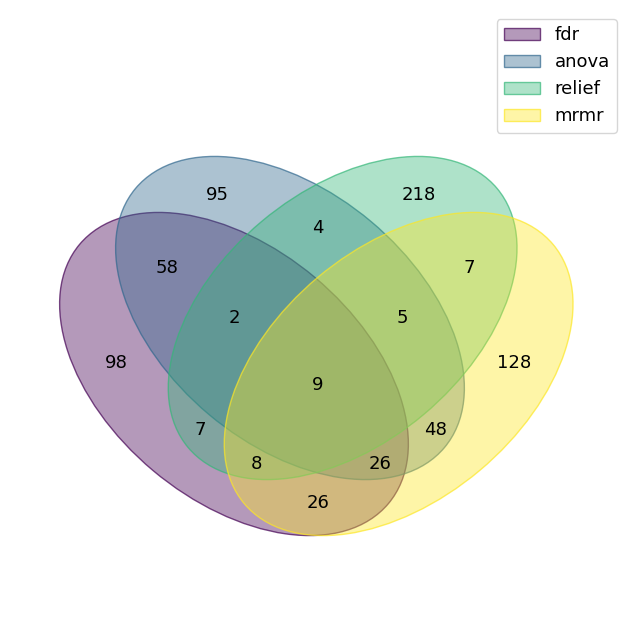

In [589]:
from venn import venn

genes_lists = {
    "fdr": set(ga_selected_fdr),
    "anova": set(ga_selected_anova),
    "relief": set(ga_selected_relief), # it has no intersection
    "mrmr": set(ga_selected_mrmr),
    #"ig":set(ga_selected_ig) 
}

venn(genes_lists)

<AxesSubplot: >

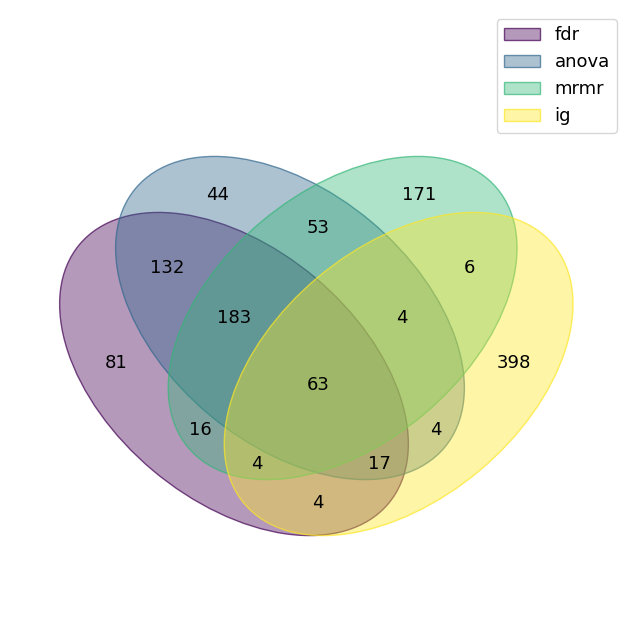

In [596]:
from venn import venn

genes_lists = {
    "fdr": set(fdr_features_indices),
    "anova": set(anova_features_index),
    #"relief": set(relief_feature_indices), # it has no intersection
    "mrmr": set(mrmr_index),
    "ig":set(ig_features_index)
}

venn(genes_lists)

<AxesSubplot: >

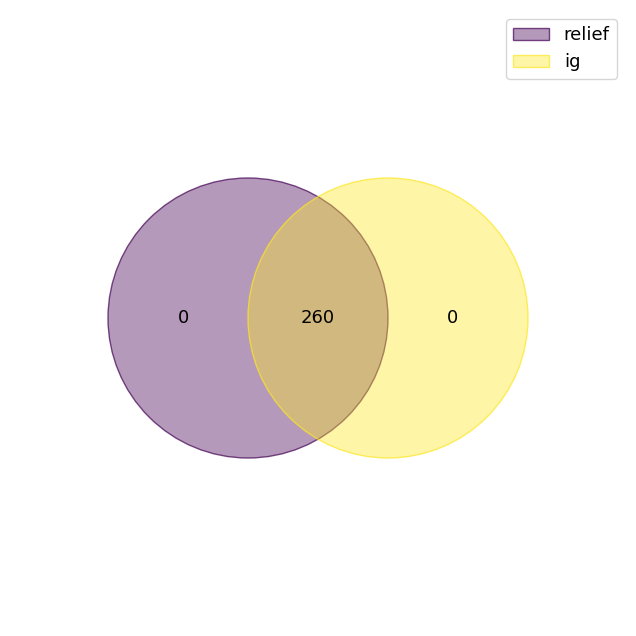

In [586]:
genes_lists = {
    #"fdr": set(ga_selected_fdr),
    #"anova": set(ga_selected_anova),
    "relief": set(ga_selected_relief), # it has no intersection
    #"mrmr": set(ga_selected_mrmr),
    "ig":set(ga_selected_ig) 
}

venn(genes_lists)

In [536]:
ga_intersections = list(set.intersection(set(ga_selected_fdr), set(ga_selected_anova), set(ga_selected_mrmr)))

In [534]:
X_train

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
GSM7500930,10.599913,8.680887,8.616181,10.847057,5.773469,9.283088,7.171927,4.517276,7.044394,7.489447,...,10.463422,2.632268,8.476544,8.873444,8.381975,10.260096,8.558038,5.632268,9.872213,9.042207
GSM7501193,10.346269,8.741774,8.828165,12.350208,6.250999,10.096237,9.425505,5.510044,7.054089,8.688061,...,10.095351,5.609105,7.899967,9.787170,9.111545,9.136155,7.321730,7.323208,10.690221,8.398248
GSM7501091,10.044879,7.793987,8.443627,11.432237,5.888719,10.018151,7.974598,7.153106,6.051394,7.594571,...,10.263081,5.628044,7.220997,8.959730,9.641450,8.757990,8.732062,8.040865,8.474760,8.791642
GSM7500918,9.465566,8.480992,8.703558,11.410398,6.915282,9.516882,7.622784,5.472488,5.197708,7.495056,...,9.842350,7.866661,7.861707,9.135966,9.471878,8.574404,7.831624,8.138528,10.635718,8.819540
GSM7501216,9.816984,8.820179,8.721099,10.666224,5.930737,10.016808,7.562242,4.169925,10.808160,7.257388,...,10.764042,7.741467,7.665336,8.539159,9.142107,9.893302,8.438792,7.734710,8.787903,8.829723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM7501056,10.618213,7.809144,8.874653,11.803851,7.374579,9.989561,8.870121,6.552177,4.583820,8.055982,...,10.173961,5.928086,8.249445,8.722217,9.623554,7.885208,7.458948,6.408015,10.431661,8.668385
GSM7501239,10.088523,8.727240,8.603255,11.627579,6.376777,9.152285,7.958843,4.193772,6.640968,7.824641,...,10.424271,4.378512,8.232661,8.988685,8.616916,8.001127,7.986411,7.674545,9.932953,7.613237
GSM7501146,9.932215,8.842350,9.187352,11.509280,6.857981,9.957102,8.721099,4.321928,2.584963,8.049849,...,9.821774,6.475733,8.005625,9.550747,8.566054,9.306062,7.607330,6.658211,10.172428,8.463524
GSM7501101,10.007027,8.710806,9.014020,11.516192,6.022368,10.391244,5.930737,5.087463,7.942515,6.392317,...,10.084808,4.700440,7.813781,9.301496,9.961450,9.353147,8.654636,9.068778,9.700440,8.603626


In [535]:
ga_intersections

['219877_at',
 '211637_x_at',
 '209374_s_at',
 '211642_at',
 '211645_x_at',
 '225822_at',
 '203200_s_at',
 '216560_x_at',
 '219006_at',
 '226351_at',
 '242042_s_at',
 '217988_at',
 '216829_at',
 '41660_at',
 '215678_at',
 '57532_at',
 '1562703_at',
 '215176_x_at',
 '215949_x_at',
 '204393_s_at',
 '211835_at',
 '217378_x_at',
 '217258_x_at',
 '201848_s_at',
 '240661_at',
 '234353_at',
 '216488_s_at',
 '211990_at',
 '211868_x_at',
 '222285_at',
 '204049_s_at',
 '223709_s_at',
 '1554556_a_at',
 '203559_s_at',
 '217179_x_at']

In [537]:
X_train_selected = X_train.iloc[:, ga_intersections]
X_val_selected = X_val.iloc[:, ga_intersections]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.8203125
[[25  7]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        32
           1       0.30      0.75      0.43         4

    accuracy                           0.78        36
   macro avg       0.63      0.77      0.65        36
weighted avg       0.89      0.78      0.81        36



In [538]:
X_test_selected = X_test.iloc[:, ga_intersections]

y_pred_prob = pipe.predict_proba(X_test_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5703125
[[25  7]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        32
           1       0.12      0.25      0.17         4

    accuracy                           0.72        36
   macro avg       0.51      0.52      0.50        36
weighted avg       0.81      0.72      0.76        36



## Relief, Gen, LASSO

In [ ]:
from sklearn.metrics import roc_auc_score
seed = 42
random.seed(seed)
# Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
X_train_f = X_train.iloc[:, relief_feature_indices]
X_val_f = X_val.iloc[:, relief_feature_indices]
y_train = y_train
y_val = y_val

# Define evaluation function with weighted accuracy based on probabilities
def evaluate(individual):
    # Create a mask to select features
    selected_features = np.array(individual).astype(bool)
    
    if sum(selected_features) == 0:
        return 0,  # Avoid having no features selected
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]
    
    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])
    
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    
    print(roc_auc)
    
    return roc_auc,

# Setup the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the Genetic Algorithm
population = toolbox.population(n=20)
ngen = 20
cxpb = 0.5
mutpb = 0.2

algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print('best_individual =', best_individual)
print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

# Evaluate the best individual to print the ROC AUC score
roc_auc = evaluate(best_individual)[0]
print('ROC AUC of the Best Individual:', roc_auc)

0.8046875
0.5859375
0.640625
0.65625
0.546875
0.7265625
0.5703125
0.5234375
0.484375
0.625
0.671875
0.6171875
0.625
0.5625
0.703125
0.609375
0.6015625
0.546875
0.484375
0.484375
gen	nevals
0  	20    
0.6484375
0.6875
0.6484375
0.7421875
0.625
0.5859375
0.734375
0.6796875
0.5546875
0.5703125
0.640625
0.59375
0.625
1  	13    
0.6328125
0.796875
0.78125
0.6171875
0.7421875
0.734375
0.5859375
0.75
0.6171875
2  	9     
0.75
0.875
0.7421875
0.7578125
0.5859375
0.625
0.8046875
0.6640625
0.7109375
0.8359375
0.71875
3  	11    
0.7421875
0.84375
0.765625
0.8359375
0.7265625
0.8359375
0.8046875
0.828125
0.8046875
0.8046875
0.75
0.8046875
0.78125
0.8046875
4  	14    
0.8125
0.828125
0.8046875
0.8359375
0.8359375
0.8125
0.8046875
0.75
0.8359375
0.8359375
5  	10    
0.828125
0.8203125
0.8515625
0.84375
0.8046875
6  	5     
0.8359375
0.8359375
0.8359375
0.8359375
0.8125
0.8515625
0.765625
0.8046875
0.890625
0.8203125
7  	10    
0.8515625
0.796875
0.8046875
0.890625
0.890625
0.7578125
0.84375
0.84375


In [ ]:
best_individual = [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
mask_relief = best_individual
ga_selected_relief = [element for element, m in zip(relief_feature_indices, mask_relief) if m]
ga_selected_relief

[3973,
 3457,
 30431,
 5664,
 8949,
 39947,
 7151,
 43063,
 9503,
 42941,
 47173,
 51434,
 25291,
 30894,
 8654,
 50949,
 43428,
 4074,
 8618,
 26290,
 53017,
 37815,
 35122,
 3185,
 45420,
 50860,
 14912,
 5104,
 57,
 30005,
 7578,
 1910,
 16655,
 25757,
 30016,
 11012,
 30594,
 13829,
 24387,
 39987,
 47436,
 45046,
 44787,
 23506,
 53459,
 52162,
 31705,
 7252,
 19745,
 16495,
 15558,
 19934,
 533,
 42864,
 9736,
 29389,
 20556,
 50635,
 30111,
 25615,
 3748,
 8952,
 8703,
 53273,
 3935,
 34651,
 47124,
 13127,
 49654,
 16730,
 3332,
 5276,
 40703,
 43910,
 22968,
 15343,
 723,
 26288,
 48209,
 8497,
 16240,
 53790,
 43450,
 46375,
 44586,
 46504,
 16308,
 3698,
 50345,
 43886,
 12900,
 4905,
 7660,
 48081,
 26021,
 5663,
 15557,
 30295,
 6432,
 1527,
 24708,
 25308,
 15498,
 21009,
 29719,
 19735,
 43940,
 5005,
 17262,
 43621,
 45438,
 5427,
 43571,
 9248,
 43524,
 50377,
 50406,
 38299,
 20960,
 8177,
 23776,
 25516,
 6898,
 22560,
 26124,
 40868,
 7149,
 5573,
 30752,
 2565,
 19

In [ ]:
X_train_selected = X_train.iloc[:, ga_selected_relief]
X_val_selected = X_val.iloc[:, ga_selected_relief]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.96875
[[30  2]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.60      0.75      0.67         4

    accuracy                           0.92        36
   macro avg       0.78      0.84      0.81        36
weighted avg       0.93      0.92      0.92        36



In [ ]:
list(X_train.columns[ga_selected_relief])

['1557991_at',
 '1557180_at',
 '221254_s_at',
 '1561025_at',
 '1569097_at',
 '230817_at',
 '1563462_at',
 '233947_s_at',
 '1570023_at',
 '233821_at',
 '238080_at',
 '242372_s_at',
 '216099_at',
 '221721_s_at',
 '1568287_at',
 '241886_x_at',
 '234313_at',
 '1558216_at',
 '1567657_at',
 '217103_at',
 '243965_at',
 '228681_x_at',
 '225983_s_at',
 '1556759_at',
 '236318_x_at',
 '241796_x_at',
 '205553_s_at',
 '1560062_at',
 '1552321_a_at',
 '220825_s_at',
 '1564460_at',
 '1554912_at',
 '207302_at',
 '216567_at',
 '220837_at',
 '201650_at',
 '221417_x_at',
 '204468_s_at',
 '215192_at',
 '230857_s_at',
 '238343_x_at',
 '235944_at',
 '235682_s_at',
 '214304_x_at',
 '244410_at',
 '243106_at',
 '222535_at',
 '1563660_at',
 '210439_at',
 '207140_at',
 '206202_at',
 '210642_at',
 '1553009_s_at',
 '233743_x_at',
 '1570391_at',
 '220209_at',
 '211307_s_at',
 '241567_at',
 '220932_at',
 '216424_at',
 '1557636_a_at',
 '1569100_a_at',
 '1568643_a_at',
 '244223_at',
 '1557891_s_at',
 '225511_at',
 '238

In [ ]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_relief])
X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_relief])
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
lasso_selected = np.nonzero(model.coef_)[1]
X_train.iloc[:, ga_selected_relief].columns[lasso_selected]

[[29  3]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.50      0.75      0.60         4

    accuracy                           0.89        36
   macro avg       0.73      0.83      0.77        36
weighted avg       0.91      0.89      0.90        36



Index(['1561025_at', '230817_at', '233821_at', '242372_s_at', '221721_s_at',
       '1568287_at', '234313_at', '1558216_at', '1556759_at', '236318_x_at',
       '241796_x_at', '220825_s_at', '1554912_at', '201650_at', '204468_s_at',
       '211307_s_at', '216424_at', '1568643_a_at', '1556980_at', '1560380_at',
       '1553266_at', '217101_at', '239120_at', '1567030_at', '206884_s_at',
       '244742_at', '234336_s_at', '237277_at', '1559686_a_at', '206201_s_at',
       '216116_at', '220539_at', '1560643_x_at', '234460_at', '241306_at',
       '241335_at', '229166_s_at', '213354_s_at', '216935_at', '231739_at',
       '210121_at', '1557713_at', '233751_at', '205358_at', '232074_at',
       '235910_x_at', '215296_at', '238112_at', '1562320_at', '210562_at',
       '220269_at', '229639_s_at', '1562139_a_at', '234029_at', '214981_at',
       '231089_at', '229973_at', '239639_at', '207177_at', '229259_at',
       '243087_at', '1569378_at', '230317_x_at', '240724_at', '226953_at',
       '15

In [539]:
from collections import Counter
all_elements = list(ga_selected_fdr) + list(ga_selected_anova) + list(ga_selected_mrmr)
element_counts = Counter(all_elements)

# Select elements present in at least 2 sets
selected_elements = {element for element, count in element_counts.items() if count >= 2}


In [541]:
X_train_selected = X_train.iloc[:, list(selected_elements)]
X_val_selected = X_val.iloc[:, list(selected_elements)]

# Using a pipeline to incorporate scaling and logistic regression
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=0.1))
])

pipe.fit(X_train_selected, y_train)
y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)
# Calculate weighted accuracy based on probabilities
roc_auc = roc_auc_score(y_val, y_pred_prob)

print(roc_auc)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.8046875
[[30  2]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.50      0.50      0.50         4

    accuracy                           0.89        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.89      0.89      0.89        36



Enrichment analysis provided coherent results highlithing the importance of specific gene clusters

## Genetic using SVM and AUC ROC

In [375]:
## Relief, Gen, LASSO
# ANOVA, GA based on AUC ROC, LASSO


seed = 42
random.seed(seed)

for feature_set in [anova_features_index, fdr_features_indices, mrmr_index, relief_feature_indices, ig_features_index]:
    filtered_feature_indices = feature_set
    # Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
    X_train_f = X_train.iloc[:, filtered_feature_indices]
    X_val_f = X_val.iloc[:, filtered_feature_indices]

    def evaluate(individual):
        # Create a mask to select features
        selected_features = np.array(individual).astype(bool)
        
        if sum(selected_features) == 0:
            return 0,  # Avoid having no features selected
        
        X_train_selected = X_train_f.iloc[:, selected_features]
        X_val_selected = X_val_f.iloc[:, selected_features]
        
        # Using a pipeline to incorporate scaling and logistic regression
        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('model', SVC(class_weight='balanced', probability=True))
        ])
        
        pipe.fit(X_train_selected, y_train)
        y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
        
        # Calculate weighted accuracy based on probabilities
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        print(roc_auc)
        
        return roc_auc,

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Run the Genetic Algorithm
    population = toolbox.population(n=20)
    ngen = 20
    cxpb = 0.5
    mutpb = 0.2

    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

    # Extract the best individual
    best_individual = tools.selBest(population, 1)[0]
    print('best_individual =', best_individual)
    print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

    # Evaluate the best individual to print the ROC AUC score
    roc_auc = evaluate(best_individual)[0]
    print('ROC AUC of the Best Individual:', roc_auc)
    mask_relief = best_individual
    ga_selected_filtered = [element for element, m in zip(filtered_feature_indices, mask_relief) if m]
    ga_selected_relief
    X_train_selected = X_train.iloc[:, ga_selected_filtered]
    X_val_selected = X_val.iloc[:, ga_selected_filtered]

    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
    ])

    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    y_pred = (y_pred_prob >= 0.5).astype(int)
    # Calculate weighted accuracy based on probabilities
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    print("Classification with features selected by the GA")
    print(roc_auc)
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))

    list(X_train.columns[ga_selected_filtered])
    model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.3)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_filtered])
    X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_filtered])
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    lasso_selected = np.nonzero(model.coef_)[1]
    X_train.iloc[:, ga_selected_filtered].columns[lasso_selected]

0.78125
0.71875
0.796875
0.7109375
0.78125
0.8125
0.75
0.7578125
0.8046875
0.7421875
0.7890625
0.78125
0.7890625
0.7890625
0.7421875
0.78125
0.75
0.703125
0.7578125
0.71875
gen	nevals
0  	20    
0.78125
0.78125
0.796875
0.796875
0.8203125
0.75
0.8046875
0.7890625
0.8359375
0.78125
0.7734375
0.703125
0.7578125
1  	13    
0.8203125
0.8046875
0.734375
0.7890625
0.8046875
0.8125
0.796875
0.7734375
0.796875
2  	9     
0.8046875
0.8203125
0.8125
0.796875
0.796875
0.78125
0.796875
0.7578125
0.796875
0.8046875
0.8203125
3  	11    
0.8046875
0.828125
0.8046875
0.8359375
0.8046875
0.8359375
0.8203125
0.8203125
0.765625
0.84375
0.78125
0.8359375
0.7890625
0.8203125
4  	14    
0.8203125
0.8125
0.8359375
0.8359375
0.828125
0.8359375
0.8359375
0.8125
0.8359375
0.8359375
5  	10    
0.84375
0.8203125
0.8203125
0.8046875
0.8046875
6  	5     
0.8359375
0.8359375
0.8359375
0.84375
0.84375
0.84375
0.8203125
0.84375
0.8203125
0.8203125
7  	10    
0.796875
0.8046875
0.78125
0.84375
0.84375
0.8046875
0.84375

# Genetic Algorithm with SVM and custom fitness function

In [928]:

# Set the seed for reproducibility
seed = 42
random.seed(seed)

def fscore(maj_distances, min_distances):
    return (sum(maj_distances)**2 / (2*len(maj_distances))) + ((sum(min_distances)**2) / (2*len(min_distances)))

for feature_set in [anova_features_index, fdr_features_indices, mrmr_index, relief_feature_indices, ig_features_index]:
    filtered_feature_indices = feature_set
    # Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
    X_train_f = X_train.iloc[:, filtered_feature_indices]
    X_val_f = X_val.iloc[:, filtered_feature_indices]

    def evaluate(individual):
        # Create a mask to select features
        selected_features = np.array(individual).astype(bool)
        
        if sum(selected_features) == 0:
            return 0,  # Avoid having no features selected
        
        X_train_selected = X_train_f.iloc[:, selected_features]
        X_val_selected = X_val_f.iloc[:, selected_features]
        
        # Using a pipeline to incorporate scaling and SVC
        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('model', SVC(kernel='linear', C=1, class_weight='balanced'))
        ])
        
        pipe.fit(X_train_selected, y_train)
        
        # Get the support vectors and coefficients
        svc = pipe.named_steps['model']
        coef = svc.coef_
        
        # Calculate distances of validation points to the hyperplane
        distance_minority_class = []
        distance_majority_class = []
        
        for i in range(X_val_selected.shape[0]):
            distance = np.dot(coef, X_val_selected.iloc[i].values)[0]
            if y_val[i] == 0:  # Assuming minority class is labeled as 0
                distance_majority_class.append(distance)
            else:
                distance_minority_class.append(distance)
                
        score = fscore(distance_majority_class, distance_minority_class)
        
        print(score)
        
        return score,

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_f.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Run the Genetic Algorithm
    population = toolbox.population(n=20)
    ngen = 20
    cxpb = 0.5
    mutpb = 0.2

    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True)

    # Extract the best individual
    best_individual = tools.selBest(population, 1)[0]
    print('Best Individual:', best_individual)
    print('Selected Features:', [i for i, x in enumerate(best_individual) if x == 1])

    # Evaluate the best individual to print the custom fitness score
    custom_score = evaluate(best_individual)[0]
    print('Custom Score of the Best Individual:', custom_score)
    mask_selected = best_individual
    ga_selected_filtered = [element for element, m in zip(filtered_feature_indices, mask_selected) if m]

    X_train_selected = X_train.iloc[:, ga_selected_filtered]
    X_val_selected = X_val.iloc[:, ga_selected_filtered]

    # Using a pipeline to incorporate scaling and logistic regression
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('model', SVC(kernel='linear', C=1, class_weight='balanced'))
    ])

    pipe.fit(X_train_selected, y_train)
    y_pred = pipe.predict(X_val_selected)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    print("Classification with features selected by the GA")
    print(f'ROC AUC: {roc_auc}')
    print(confusion_matrix(y_val, y_pred))
    # print(classification_report(y_val, y_pred))

    # # Logistic regression with L1 regularization (LASSO)
    # model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.3)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train.iloc[:, ga_selected_filtered])
    # X_val_scaled = scaler.transform(X_val.iloc[:, ga_selected_filtered])
    # model.fit(X_train_scaled, y_train)
    # y_pred = model.predict(X_val_scaled)
    # print(confusion_matrix(y_val, y_pred))
    # print(classification_report(y_val, y_pred))
    # lasso_selected = np.nonzero(model.coef_)[1]
    # print(X_train.iloc[:, ga_selected_filtered].columns[lasso_selected])


1173.187282163919
15618.888255488555
7638.322264780478
11051.337167587582
6687.199590653177
14294.41837784139
15978.645780705767
9612.781195006472
31509.862563327246
13277.422966895623
121.49740673869366
25313.729729124585
29093.649869289566
3352.6516379733757
11662.502255278896
8412.351132299103
13382.172575400251
12039.092151757462
23147.839841541983
20788.534181833016
gen	nevals
0  	20    
17779.914473590445
9730.071969122266
9615.197675027659
9233.601854988126
14581.544814369045
20410.12096615139
20000.854808047985
1498.3916736461338
9971.602460471611
16509.976151908588
19117.590744846908
33456.9229530496
18871.065857793565
1  	13    
9884.736622272796
8157.683681834373
20762.919935211412
29093.649869289566
23673.033384840513
35386.976623090886
14165.736207901662
28139.90089585386
33721.63267181119
27886.621773588828
15284.175273343471
25019.31321643337
23198.432591599878
26338.63982957705
16982.367958637453
18026.102632453156
25957.890792113358
2  	17    
16825.478942445494
19457.

# SVM-RFE

In [929]:
import random
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Set the seed for reproducibility
seed = 42
random.seed(seed)

for feature_set in [anova_features_index, fdr_features_indices, mrmr_index, relief_feature_indices, ig_features_index]:
    filtered_feature_indices = feature_set
    # Assuming X_train, y_train, X_val, y_val are defined somewhere in your environment
    X_train_f = X_train.iloc[:, filtered_feature_indices]
    X_val_f = X_val.iloc[:, filtered_feature_indices]

    # Using a pipeline to incorporate scaling and SVC
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=40)),
        ('model', LogisticRegression(class_weight='balanced', max_iter=1000, C=1))
    ])

    # Fit the pipeline
    pipe.fit(X_train_f, y_train)
    
    # Get the selected features
    selected_features = pipe.named_steps['rfe'].support_
    
    X_train_selected = X_train_f.iloc[:, selected_features]
    X_val_selected = X_val_f.iloc[:, selected_features]

    # Refit the pipeline with selected features
    pipe.fit(X_train_selected, y_train)
    y_pred_prob = pipe.predict_proba(X_val_selected)[:, 1]
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    print("Classification with features selected by SVM-RFE")
    print(f'ROC AUC: {roc_auc}')
    print(confusion_matrix(y_val, y_pred))
    print(classification_report(y_val, y_pred))

    selected_feature_names = X_train_f.columns[selected_features]
    print("Selected Features:", selected_feature_names.tolist())

    # Logistic regression with L1 regularization (LASSO)
    # model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, class_weight='balanced', C=0.3)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train.iloc[:, selected_features])
    # X_val_scaled = scaler.transform(X_val.iloc[:, selected_features])
    # model.fit(X_train_scaled, y_train)
    # y_pred = model.predict(X_val_scaled)
    # print(confusion_matrix(y_val, y_pred))
    # print(classification_report(y_val, y_pred))
    # lasso_selected = np.nonzero(model.coef_)[1]
    # print(X_train.iloc[:, selected_features].columns[lasso_selected])


Classification with features selected by SVM-RFE
ROC AUC: 0.6796875
[[27  5]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.29      0.50      0.36         4

    accuracy                           0.81        36
   macro avg       0.61      0.67      0.62        36
weighted avg       0.86      0.81      0.83        36

Selected Features: ['1561937_x_at', '1565535_x_at', '201848_s_at', '202716_at', '207399_at', '209374_s_at', '210538_s_at', '211637_x_at', '211640_x_at', '211642_at', '211643_x_at', '211650_x_at', '211798_x_at', '211835_at', '211881_x_at', '211991_s_at', '213489_at', '214768_x_at', '214916_x_at', '215176_x_at', '215621_s_at', '216401_x_at', '216430_x_at', '216510_x_at', '216541_x_at', '216542_x_at', '216853_x_at', '217084_at', '217145_at', '217148_x_at', '217227_x_at', '217360_x_at', '217378_x_at', '217390_x_at', '222641_s_at', '225822_at', '232531_at', '234764_x_at', '234851_at',

# Integrative Gene Selection

This approach follows the considerations of Fang et al.

In [395]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

info_gain_scores = mutual_info_classif(X_train, y_train)

# Create a DataFrame to hold the feature names and their corresponding InfoGain scores
info_gain_df = pd.DataFrame({
    'Feature': X_train.columns,
    'InfoGain': info_gain_scores
})

# Sort the DataFrame by InfoGain scores in descending order
info_gain_df = info_gain_df.sort_values(by='InfoGain', ascending=False)

# Display the DataFrame
print(info_gain_df)


            Feature  InfoGain
26567   217384_x_at  0.120687
28537     219355_at  0.092435
4921     1559711_at  0.088175
26019     216829_at  0.087452
8956   1569106_s_at  0.086591
...             ...       ...
30008   220828_s_at  0.000000
30007     220827_at  0.000000
30006     220826_at  0.000000
7583     1564469_at  0.000000
6376     1562145_at  0.000000

[54411 rows x 2 columns]


In [396]:
info_gain_df = info_gain_df[info_gain_df['InfoGain'] > 0]


In [397]:
info_gain_df

,Feature,InfoGain
26567,217384_x_at,1.206869e-01
28537,219355_at,9.243515e-02
4921,1559711_at,8.817492e-02
26019,216829_at,8.745188e-02
8956,1569106_s_at,8.659058e-02
...,...,...
54408,91826_at,9.498878e-06
15732,206376_at,6.644190e-06
52262,243206_at,6.286184e-06
33095,223934_at,5.944076e-06


In [400]:
from mygene import MyGeneInfo


In [404]:
affy_ids = list(info_gain_df['Feature']) # Replace with your actual Affymetrix IDs
mg = MyGeneInfo()
query_results = mg.querymany(affy_ids, scopes='reporter', fields='symbol,entrezgene', species='human')

# Create a DataFrame with the conversion results
conversion_name = pd.DataFrame(query_results)


977 input query terms found dup hits:	[('216829_at', 2), ('216557_x_at', 6), ('1561937_x_at', 4), ('214916_x_at', 7), ('210070_s_at', 2), 
5716 input query terms found no hit:	['217384_x_at', '244408_at', '242181_at', '236474_at', '1559795_at', '1563112_at', '241086_at', '156


             query notfound    _id     _score entrezgene   symbol
0      217384_x_at     True    NaN        NaN        NaN      NaN
1        219355_at      NaN  55086  19.853115      55086     RADX
2       1559711_at      NaN  23196  18.729270      23196  FAM120A
3        216829_at      NaN  50802  18.149052      50802      IGK
4        216829_at      NaN   3514  18.149052       3514     IGKC
...            ...      ...    ...        ...        ...      ...
30105     91826_at      NaN  54869  19.750320      54869   EPS8L1
30106    206376_at      NaN  55117  18.731394      55117  SLC6A15
30107    243206_at      NaN  90799  19.853115      90799    CEP95
30108    223934_at      NaN  93349  19.853115      93349   SP140L
30109  216026_s_at      NaN   5426  18.168410       5426     POLE

[30110 rows x 6 columns]


In [410]:
conversion_name["entrezgene"].isna().sum(), conversion_name["symbol"].isna().sum()

(5716, 5716)

In [411]:
conversion_name

,query,notfound,_id,_score,entrezgene,symbol
0,217384_x_at,True,NaN,NaN,NaN,NaN
1,219355_at,NaN,55086,19.853115,55086,RADX
2,1559711_at,NaN,23196,18.729270,23196,FAM120A
3,216829_at,NaN,50802,18.149052,50802,IGK
4,216829_at,NaN,3514,18.149052,3514,IGKC
...,...,...,...,...,...,...
30105,91826_at,NaN,54869,19.750320,54869,EPS8L1
30106,206376_at,NaN,55117,18.731394,55117,SLC6A15
30107,243206_at,NaN,90799,19.853115,90799,CEP95
30108,223934_at,NaN,93349,19.853115,93349,SP140L


# Ensemble

In [495]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

def normalize_and_discretize(data):
    # Normalize data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    
    # Discretize data into three partitions
    bins = [-np.inf, -0.5, 0.5, np.inf]
    discretized_data = np.digitize(normalized_data, bins) - 1
    return discretized_data

def calculate_icc(gene, classes):
    """Calculate the Information Correlation Coefficient (ICC)"""
    mutual_info = mutual_info_classif(gene.reshape(-1, 1), classes, discrete_features=True)[0]
    joint_entropy = -np.sum([p * np.log2(p) for p in np.bincount(gene) / len(gene) if p > 0])
    icc = mutual_info / joint_entropy if joint_entropy != 0 else 0
    return icc

def calculate_icc_between_genes(gene1, gene2):
    """Calculate the ICC between two genes"""
    joint_mutual_info = mutual_info_classif(np.array([gene1, gene2]).T, gene2, discrete_features=True)[0]
    joint_entropy = -np.sum([p * np.log2(p) for p in np.bincount(gene1 * len(np.unique(gene2)) + gene2) / len(gene1) if p > 0])
    icc = joint_mutual_info / joint_entropy if joint_entropy != 0 else 0
    return icc

def markov_blanket_center(gene_icc, gene_center_icc, gene_pair_icc):
    """Determine if the gene center is the approximate Markov blanket of the gene"""
    return gene_center_icc >= gene_icc and gene_pair_icc >= gene_icc

def group_genes_by_icc(data, classes):
    gene_names = data.columns
    icc_values = []

    # Step 1: Initialize the set of gene groups GS as an empty set
    gene_groups = []

    # Normalize and discretize data
    discretized_data = normalize_and_discretize(data.values)
    
    # Step 2: Calculate ICC for each gene and sort them
    gene_icc_dict = {}
    for idx, gene_name in enumerate(gene_names):
        gene = discretized_data[:, idx]
        icc = calculate_icc(gene, classes)
        gene_icc_dict[gene_name] = icc
        icc_values.append((gene_name, icc))

    icc_values.sort(key=lambda x: x[1], reverse=True)

    # Step 3: Assign the first gene to a new group G1 and label it as the center
    first_gene = icc_values[0][0]
    gene_groups.append({'center': first_gene, 'genes': [first_gene]})

    # Step 4: Group remaining genes
    for gene_name, icc in icc_values[1:]:
        grouped = False
        gene = discretized_data[:, gene_names.get_loc(gene_name)]
        for group in gene_groups:
            center_gene_name = group['center']
            center_gene = discretized_data[:, gene_names.get_loc(center_gene_name)]
            center_icc = gene_icc_dict[center_gene_name]
            gene_pair_icc = calculate_icc_between_genes(center_gene, gene)
            if markov_blanket_center(icc, center_icc, gene_pair_icc):
                group['genes'].append(gene_name)
                grouped = True
                break
        if not grouped:
            gene_groups.append({'center': gene_name, 'genes': [gene_name]})

    # Step 5: All genes have been grouped
    return gene_groups

# Example usage:
# Assuming `microarray_data` is a pandas DataFrame where rows are samples and columns are genes
# Assuming `target_classes` is a pandas Series with the class labels for each sample

# Example data for testing

# Process and group genes
gene_groups = group_genes_by_icc(X_train, y_train)
print(gene_groups)


[{'center': '217384_x_at', 'genes': ['217384_x_at', '211908_x_at', '217235_x_at', '216829_at', '234419_x_at', '216984_x_at', '216576_x_at', '216510_x_at', '211835_at', '234884_x_at', '215176_x_at', '1555711_x_at', '217145_at', '211648_at', '211650_x_at', '216560_x_at', '211639_x_at', '211641_x_at', '222235_s_at', '1561937_x_at', '40189_at', '216542_x_at', '211798_x_at', '216557_x_at', '1565535_x_at', '234764_x_at', '216401_x_at', '216517_at', '217236_x_at', '217320_at', '216412_x_at', '234366_x_at', '217480_x_at', '214777_at', '211642_at', '234851_at', '211655_at', '216365_x_at', '215621_s_at', '214916_x_at', '217084_at', '215777_at', '217360_x_at', '211645_x_at', '214768_x_at', '222285_at', '233255_s_at', '215214_at', '217227_x_at', '1558176_at', '234477_at', '211881_x_at', '223266_at', '209018_s_at', '216207_x_at', '217258_x_at', '204780_s_at', '1565282_at', '217369_at', '223640_at', '222761_at', '217148_x_at', '211637_x_at', '211647_x_at', '216853_x_at', '211868_x_at', '234381_at', 

In [496]:
len(gene_groups)

240

In [497]:

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

def normalize_and_discretize(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    bins = [-np.inf, -0.5, 0.5, np.inf]
    discretized_data = np.digitize(normalized_data, bins) - 1
    return discretized_data

def calculate_icc(gene, classes):
    mutual_info = mutual_info_classif(gene.reshape(-1, 1), classes, discrete_features=True)[0]
    joint_entropy = -np.sum([p * np.log2(p) for p in np.bincount(gene) / len(gene) if p > 0])
    icc = mutual_info / joint_entropy if joint_entropy != 0 else 0
    return icc

def calculate_icc_between_genes(gene1, gene2):
    joint_mutual_info = mutual_info_classif(np.array([gene1, gene2]).T, gene2, discrete_features=True)[0]
    joint_entropy = -np.sum([p * np.log2(p) for p in np.bincount(gene1 * len(np.unique(gene2)) + gene2) / len(gene1) if p > 0])
    icc = joint_mutual_info / joint_entropy if joint_entropy != 0 else 0
    return icc

def markov_blanket_center(gene_icc, gene_center_icc, gene_pair_icc):
    return gene_center_icc >= gene_icc and gene_pair_icc >= gene_icc

def group_genes_by_icc(data, classes):
    gene_names = data.columns
    icc_values = []
    gene_groups = []
    discretized_data = normalize_and_discretize(data.values)
    gene_icc_dict = {}

    for idx, gene_name in enumerate(gene_names):
        gene = discretized_data[:, idx]
        icc = calculate_icc(gene, classes)
        gene_icc_dict[gene_name] = icc
        icc_values.append((gene_name, icc))

    icc_values.sort(key=lambda x: x[1], reverse=True)
    first_gene = icc_values[0][0]
    gene_groups.append({'center': first_gene, 'genes': [first_gene]})

    for gene_name, icc in icc_values[1:]:
        grouped = False
        gene = discretized_data[:, gene_names.get_loc(gene_name)]
        for group in gene_groups:
            center_gene_name = group['center']
            center_gene = discretized_data[:, gene_names.get_loc(center_gene_name)]
            center_icc = gene_icc_dict[center_gene_name]
            gene_pair_icc = calculate_icc_between_genes(center_gene, gene)
            if markov_blanket_center(icc, center_icc, gene_pair_icc):
                group['genes'].append(gene_name)
                grouped = True
                break
        if not grouped:
            gene_groups.append({'center': gene_name, 'genes': [gene_name]})

    return gene_groups

def select_representative_genes(gene_groups, gene_icc_dict, top_t=15):
    representatives = []
    for group in gene_groups:
        sorted_genes = sorted(group['genes'], key=lambda g: gene_icc_dict[g], reverse=True)[:top_t]
        representatives.append(np.random.choice(sorted_genes))
    return representatives

def generate_gene_subsets(gene_groups, gene_icc_dict, p, top_t=15):
    gene_subsets = []
    for _ in range(p):
        gene_subsets.append(select_representative_genes(gene_groups, gene_icc_dict, top_t))
    return gene_subsets



discrete_data = normalize_and_discretize(X_train)
# Group genes
gene_groups = group_genes_by_icc(X_train, y_train)
# Generate gene subsets


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [503]:
gene_names = X_train.columns
gene_icc_dict = {}
for idx, gene_name in enumerate(gene_names):
    gene = discrete_data[:, idx]
    icc = calculate_icc(gene, y_train)
    gene_icc_dict[gene_name] = icc

In [505]:
gene_subsets = generate_gene_subsets(gene_groups, gene_icc_dict, p=10, top_t=15)

In [515]:
def build_classifiers(data, classes, gene_subsets):
    classifiers = []
    for i, subset in enumerate(gene_subsets):
        subset_data = data[subset]
        nb_classifier = GaussianNB()
        nb_classifier.fit(subset_data, classes)
        classifiers.append((f'nb_{i}', nb_classifier))
    return classifiers

def ensemble_classifier(data, classes, gene_subsets):
    classifiers = build_classifiers(data, classes, gene_subsets)
    # Flatten the list of classifiers and ensure unique names
    flattened_classifiers = [(name, clf) for pair in classifiers for name, clf in [pair]]
    ensemble = VotingClassifier(estimators=flattened_classifiers, voting='hard')
    return ensemble

In [525]:
gene_groups

[{'center': '217384_x_at',
  'genes': ['217384_x_at',
   '211908_x_at',
   '217235_x_at',
   '216829_at',
   '234419_x_at',
   '216984_x_at',
   '216576_x_at',
   '216510_x_at',
   '211835_at',
   '234884_x_at',
   '215176_x_at',
   '1555711_x_at',
   '217145_at',
   '211648_at',
   '211650_x_at',
   '216560_x_at',
   '211639_x_at',
   '211641_x_at',
   '222235_s_at',
   '1561937_x_at',
   '40189_at',
   '216542_x_at',
   '211798_x_at',
   '216557_x_at',
   '1565535_x_at',
   '234764_x_at',
   '216401_x_at',
   '216517_at',
   '217236_x_at',
   '217320_at',
   '216412_x_at',
   '234366_x_at',
   '217480_x_at',
   '214777_at',
   '211642_at',
   '234851_at',
   '211655_at',
   '216365_x_at',
   '215621_s_at',
   '214916_x_at',
   '217084_at',
   '215777_at',
   '217360_x_at',
   '211645_x_at',
   '214768_x_at',
   '222285_at',
   '233255_s_at',
   '215214_at',
   '217227_x_at',
   '1558176_at',
   '234477_at',
   '211881_x_at',
   '223266_at',
   '209018_s_at',
   '216207_x_at',
   '217

In [526]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def normalize_and_discretize(data, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    
    bins = [-np.inf, -0.5, 0.5, np.inf]
    discretized_data = np.digitize(normalized_data, bins) - 1
    return discretized_data, scaler

def calculate_icc(gene, classes):
    mutual_info = mutual_info_classif(gene.reshape(-1, 1), classes, discrete_features=True)[0]
    gene_discrete = gene.astype(int)
    joint_entropy = -np.sum([p * np.log2(p) for p in np.bincount(gene_discrete) / len(gene) if p > 0])
    icc = mutual_info / joint_entropy if joint_entropy != 0 else 0
    return icc

def calculate_icc_between_genes(gene1, gene2):
    joint_mutual_info = mutual_info_classif(np.array([gene1, gene2]).T, gene2, discrete_features=True)[0]
    joint_entropy = -np.sum([p * np.log2(p) for p in np.bincount((gene1 * len(np.unique(gene2)) + gene2)) / len(gene1) if p > 0])
    icc = joint_mutual_info / joint_entropy if joint_entropy != 0 else 0
    return icc

def markov_blanket_center(gene_icc, gene_center_icc, gene_pair_icc):
    return gene_center_icc >= gene_icc and gene_pair_icc >= gene_icc

def group_genes_by_icc(data, classes):
    gene_names = data.columns
    icc_values = []
    gene_groups = []
    discretized_data, scaler = normalize_and_discretize(data.values)
    gene_icc_dict = {}

    for idx, gene_name in enumerate(gene_names):
        gene = discretized_data[:, idx]
        icc = calculate_icc(gene, classes)
        gene_icc_dict[gene_name] = icc
        icc_values.append((gene_name, icc))

    icc_values.sort(key=lambda x: x[1], reverse=True)
    first_gene = icc_values[0][0]
    gene_groups.append({'center': first_gene, 'genes': [first_gene]})

    for gene_name, icc in icc_values[1:]:
        grouped = False
        gene = discretized_data[:, gene_names.get_loc(gene_name)]
        for group in gene_groups:
            center_gene_name = group['center']
            center_gene = discretized_data[:, gene_names.get_loc(center_gene_name)]
            center_icc = gene_icc_dict[center_gene_name]
            gene_pair_icc = calculate_icc_between_genes(center_gene, gene)
            if markov_blanket_center(icc, center_icc, gene_pair_icc):
                group['genes'].append(gene_name)
                grouped = True
                break
        if not grouped:
            gene_groups.append({'center': gene_name, 'genes': [gene_name]})

    return gene_groups, gene_icc_dict, scaler

def select_representative_genes(gene_groups, gene_icc_dict, top_t=15):
    representatives = []
    for group in gene_groups:
        sorted_genes = sorted(group['genes'], key=lambda g: gene_icc_dict[g], reverse=True)[:top_t]
        representatives.append(np.random.choice(sorted_genes))
    return representatives

def generate_gene_subsets(gene_groups, gene_icc_dict, p, top_t=15):
    gene_subsets = []
    for _ in range(p):
        gene_subsets.append(select_representative_genes(gene_groups, gene_icc_dict, top_t))
    return gene_subsets

def build_classifiers(data, classes, gene_subsets):
    classifiers = []
    for i, subset in enumerate(gene_subsets):
        subset_data = data[subset]
        nb_classifier = GaussianNB()
        nb_classifier.fit(subset_data, classes)
        classifiers.append((f'nb_{i}', nb_classifier))
    return classifiers

def ensemble_classifier(data, classes, gene_subsets):
    classifiers = build_classifiers(data, classes, gene_subsets)
    flattened_classifiers = [(name, clf) for pair in classifiers for name, clf in [pair]]
    ensemble = VotingClassifier(estimators=flattened_classifiers, voting="soft")
    return ensemble

def preprocess_validation_data(validation_data, scaler):
    discretized_data, _ = normalize_and_discretize(validation_data.values, scaler)
    return pd.DataFrame(discretized_data, columns=validation_data.columns)

def train_and_evaluate(X_train, y_train, X_val, y_val, p=10, top_t=15):
    # Group genes and build ICC dictionary
    gene_groups, gene_icc_dict, scaler = group_genes_by_icc(X_train, y_train)
    # Generate gene subsets
    gene_subsets = generate_gene_subsets(gene_groups, gene_icc_dict, p, top_t)
    # Build and train ensemble classifier
    ensemble = ensemble_classifier(X_train, y_train, gene_subsets)
    ensemble.fit(X_train, y_train)

    # Preprocess validation data
    X_val_processed = preprocess_validation_data(X_val, scaler)

    # Predict on validation data
    y_pred = ensemble.predict(X_val_processed)

    # Evaluate the performance
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy with top_t={top_t}: {accuracy}')
    print(confusion_matrix(y_val, y_pred))
    return accuracy


In [938]:
icc_features = [key for key, value in sorted(gene_icc_dict.items(), key=lambda item: item[1], reverse=True)[:100]]

In [930]:
valori_center = [network['center'] for network in gene_groups]

In [935]:
X_train_selected = X_train[valori_center]
X_val_selected = X_val[valori_center]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Train the model
model = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[30  2]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.50      0.50      0.50         4

    accuracy                           0.89        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.89      0.89      0.89        36



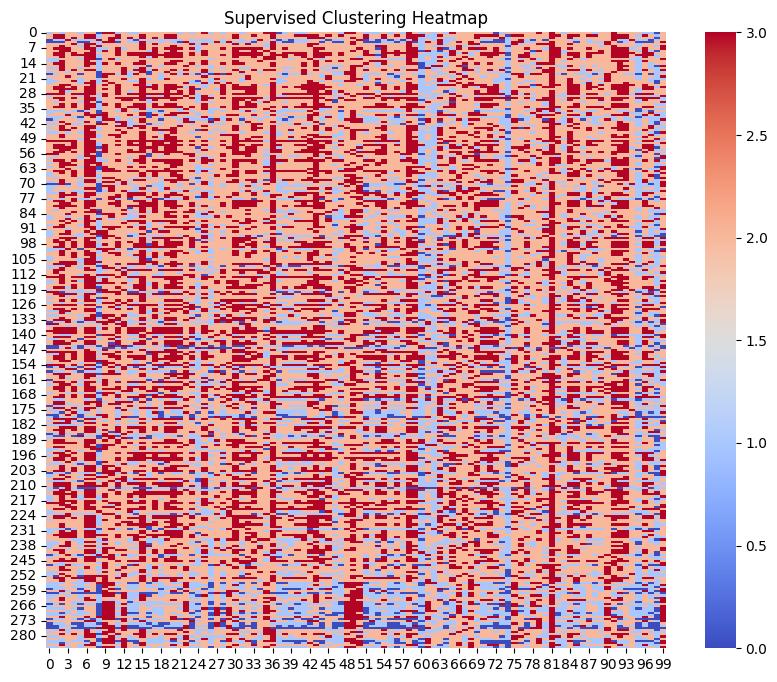

In [941]:
scaler = MinMaxScaler()
df = X_train[icc_features]
df['state'] = y_train

# Sort data by labels to cluster similar classes together
df = df.sort_values(by='state')
data_sorted = df.drop(columns='state')
data_scaled = scaler.fit_transform(data_sorted)
data_discretized = np.digitize(data_scaled, bins=np.linspace(0, 1, n_bins + 1)[1:-1])

# Standardize the data (optional but helps with better visualization)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_discretized, cmap='coolwarm', cbar=True)
plt.title('Supervised Clustering Heatmap')
plt.show()